In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

# 指定工作文件夹
work_folder_path = exception_folder_paths[3]

In [2]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [91]:
from sklearn.preprocessing import StandardScaler

def dataSampling(var_data, var_rate, wshr_data, sampling_idx_list):
    # 对每个变量按照rate进行下采样或过采样
    if var_rate == 1:
        sampling_data = var_data
    else: # 进行重采样
        sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
    selected_sampling_data = []
    for i in sampling_idx_list:
        selected_sampling_data.append(sampling_data[i])
    # # 将采样数据进行min_max归一化
    # if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
    #     sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
    # else:
    #     sampling_data = sampling_data
    return selected_sampling_data

def dataConstruct_partial(work_folder_path, work_mat_name, detect_half_bound=30, variable_list=[], is_all_variable = False, false_alarm_remove = False):
    # 读取工作mat
    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]
    wshr_warn_idx_list = np.where(wshr_data == 0)[0]
    sampling_idx_list = []
    for idx in wshr_warn_idx_list:
        for i in range(max(idx-detect_half_bound, 0), min(idx+detect_half_bound, len(wshr_data)-1)+1):
            sampling_idx_list.append(i)
    sampling_idx_list = list(set(sampling_idx_list))
    # print(wshr_warn_idx_list)
    # print(sampling_idx_list)

    if not is_all_variable:
        for var_name in variable_list:
            var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
            sampling_data = dataSampling(var_data, var_rate, wshr_data, sampling_idx_list)
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_list.append(sampling_data)
    else:
        for var_list in var_groups_dict.values():
            for var_name in var_list:
                var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
                sampling_data = dataSampling(var_data, var_rate, wshr_data, sampling_idx_list)
                # print(np.max(sampling_data), np.min(sampling_data))
                sampling_data_list.append(sampling_data)
        # sampling_data_list = np.squeeze(np.array(sampling_data_list))

    # 生成解释变量X和分类变量Y
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data[sampling_idx_list]).reshape(-1,1)
    if false_alarm_remove:
        for time in [0,1,2]:
            Y[time] = 1

    # 数据标准化
    s_scaler = StandardScaler()
    X = s_scaler.fit_transform(X)

    wshr_class_idx = [np.where(wshr_data == 0)[0], np.where(wshr_data == 1)[0]]
    if false_alarm_remove:
        for time in [0,1,2]:
            wshr_class_idx[0] = np.delete(wshr_class_idx[0], np.where(wshr_class_idx[0]==time))

    if len(wshr_class_idx[0]) > 0:
        center_idx = wshr_class_idx[0][len(wshr_class_idx[0]) // 2]
        left_len = np.where(np.array(sampling_idx_list) == center_idx)[0][0]
        right_len = len(sampling_idx_list) - left_len - 1
        # print(left_len, right_len, len(sampling_idx_list))
    else:
        left_len = len(sampling_idx_list) // 2
        right_len = len(sampling_idx_list) // 2

    # print(X.shape, Y.shape)
    print(f"Wind Shear Warns at time {wshr_class_idx[0]}")

    # if not is_all_variable:
    #     # 绘制X的时间变化
    #     plt.figure()
    #     plt.plot(range(len(wshr_data)), X[:, 0], label='Wind Speed')
    #     plt.plot(range(len(wshr_data)), X[:, 1], label='Wind Direction')
    #     plt.plot(range(len(wshr_data)), X[:, 2], label='True Air Speed')
    #     plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
    #     plt.xlabel('time(s)')
    #     plt.ylabel('WS/WD/TAS & WSHR')
    #     plt.title('Normalized WS/WD/TAS and WSHR')
    #     plt.legend()
    #     # if np.std(X[:, 2]) > 1e-1:
    #     #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    #     plt.show()

    #     # 绘制X的三维散点图
    #     fig = plt.figure(figsize=(5, 5))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
    #     ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
    #     ax.set_xlabel(variable_list[0])
    #     ax.set_ylabel(variable_list[1])
    #     ax.set_zlabel(variable_list[2])
    #     ax.legend()
    #     plt.tight_layout()
    #     plt.show()

    return X, Y, [left_len, right_len]

Wind Shear Warns at time [723 724 725 726 727 728 729]
Wind Shear Warns at time [3 4 5 6]
Wind Shear Warns at time [938 939 940 941 942 943]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [12]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]
Wind Shear Warns at time []
Wind Shear Warns at time []


C:\Users\86108\AppData\Local\Temp\ipykernel_58668\1917142417.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_array = np.array(Y_array)


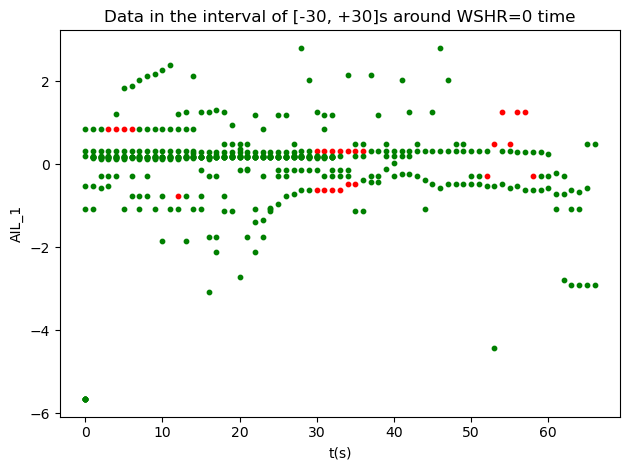

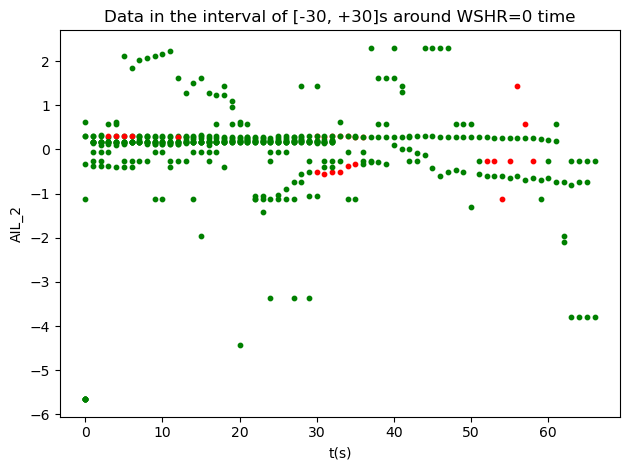

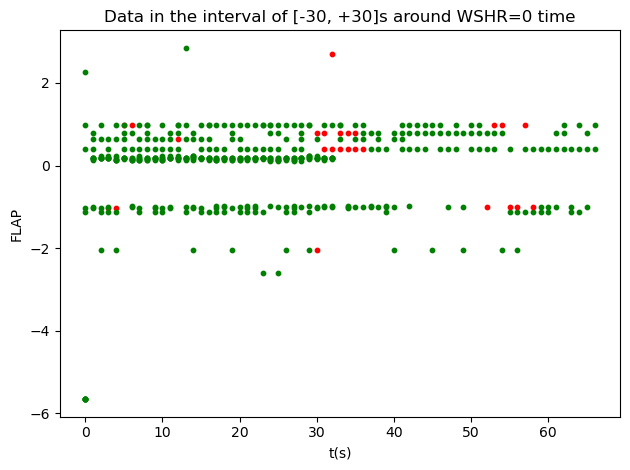

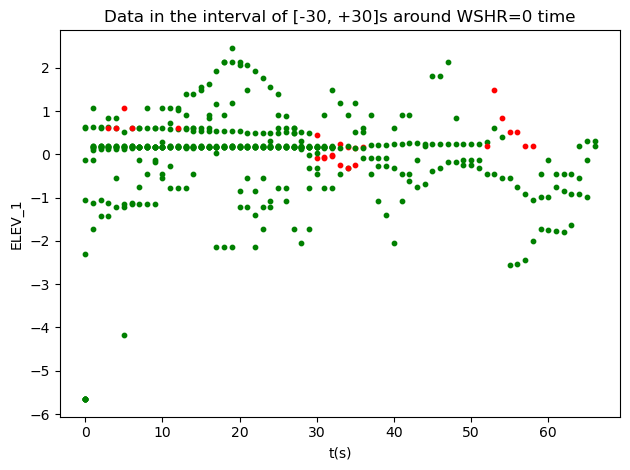

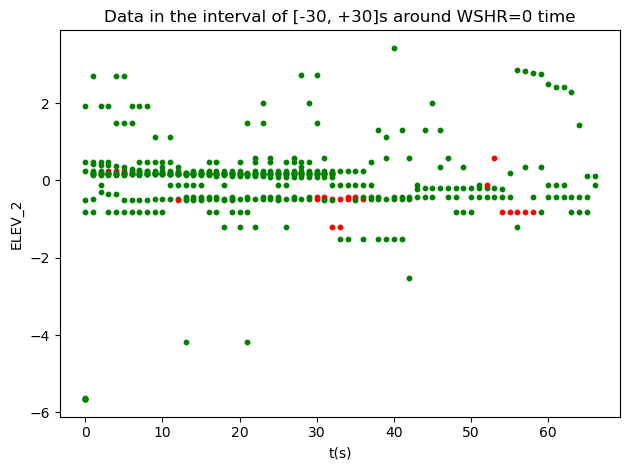

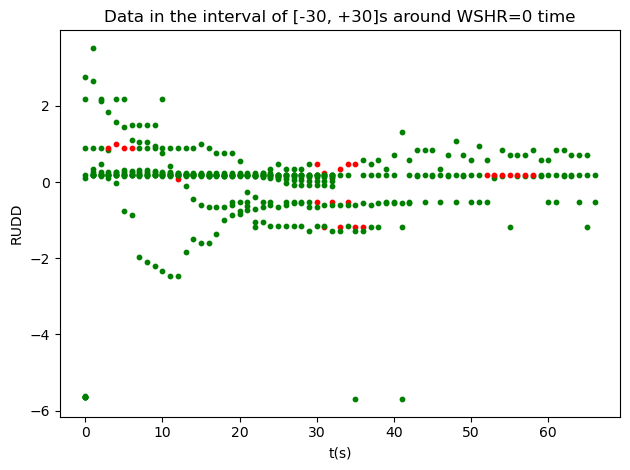

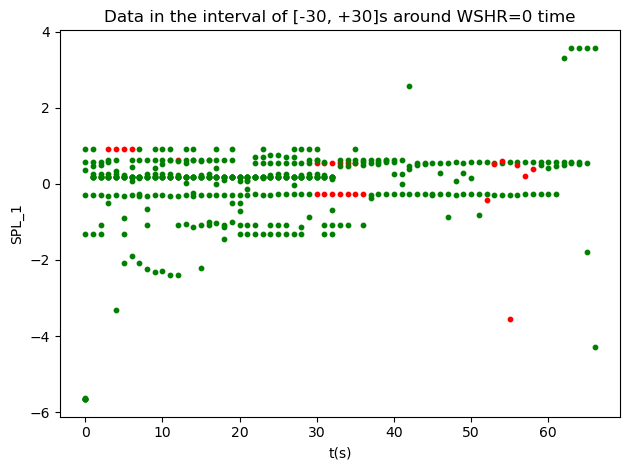

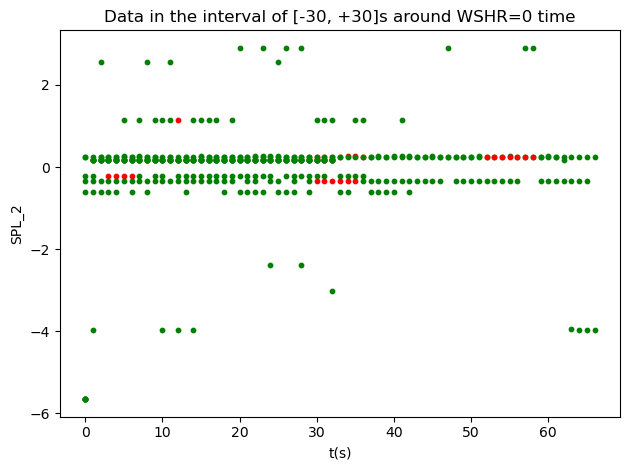

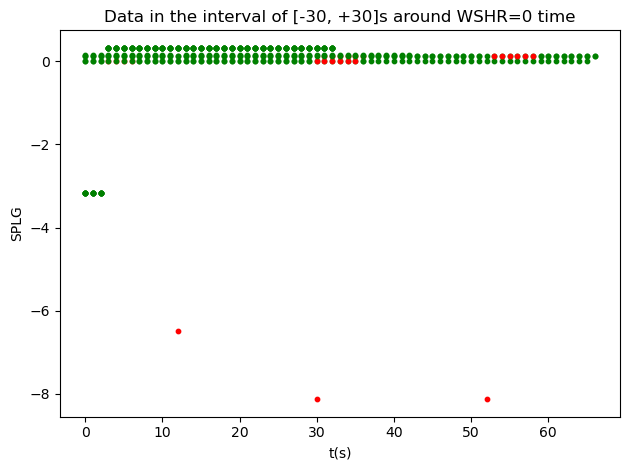

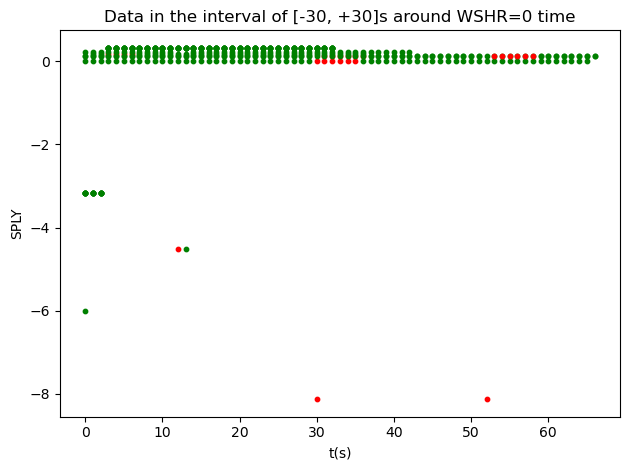

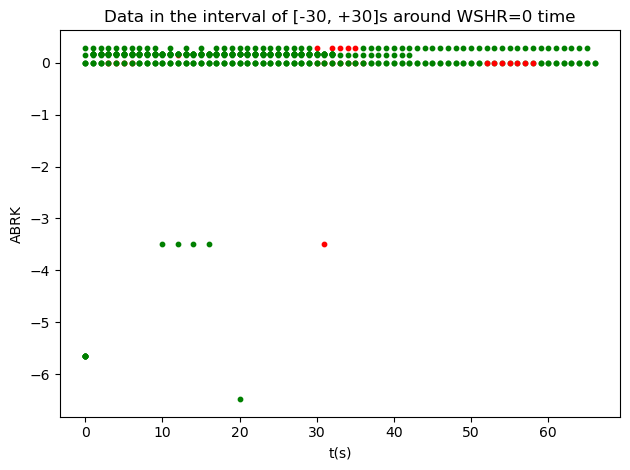

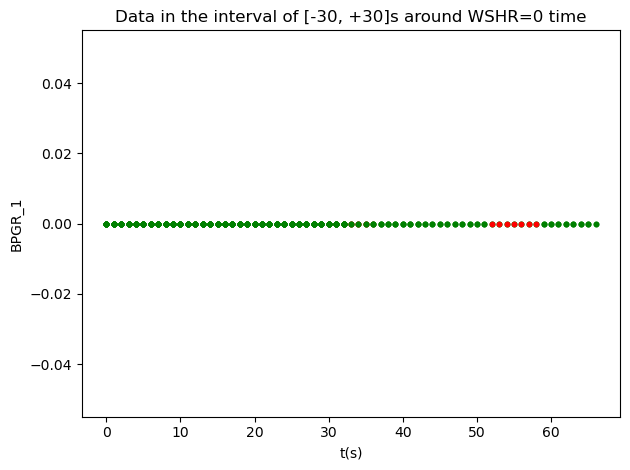

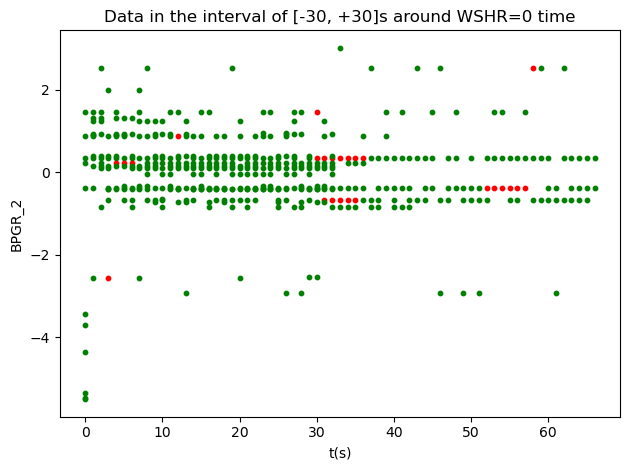

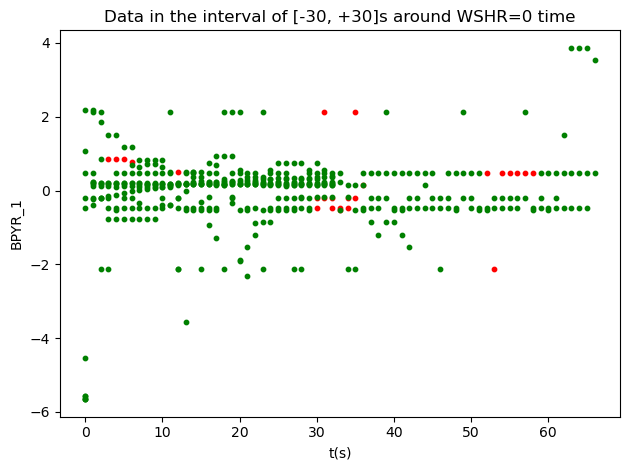

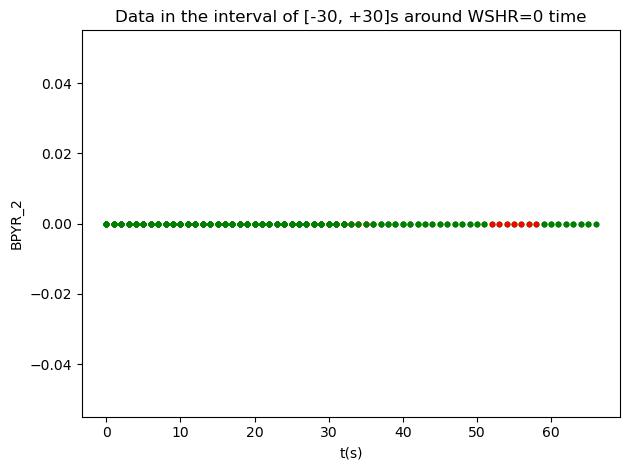

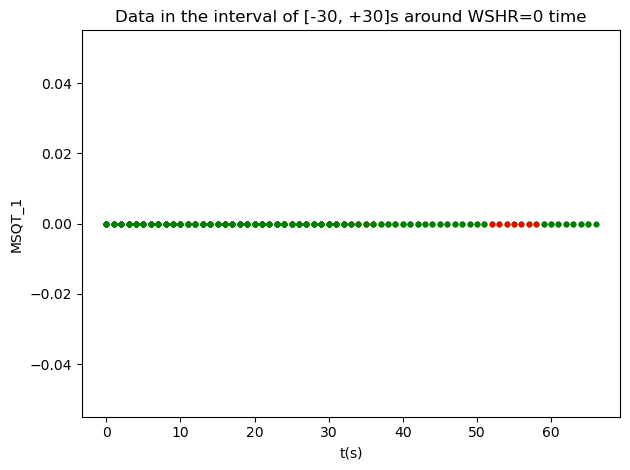

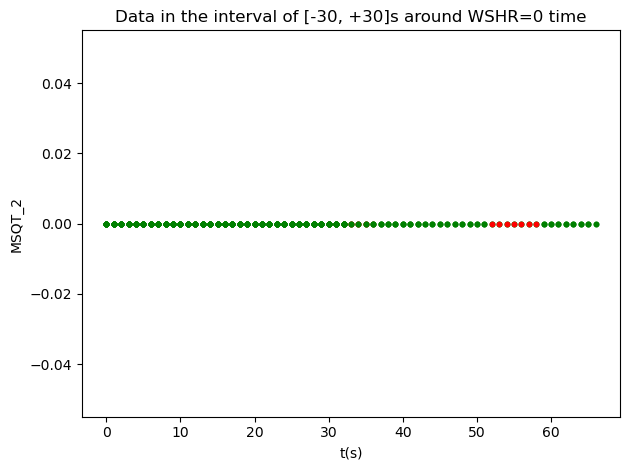

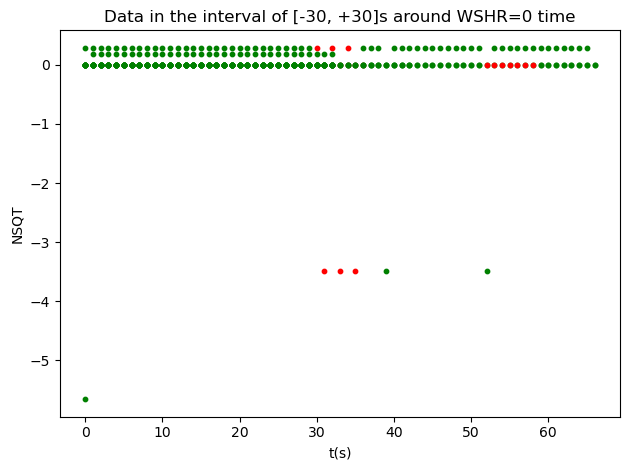

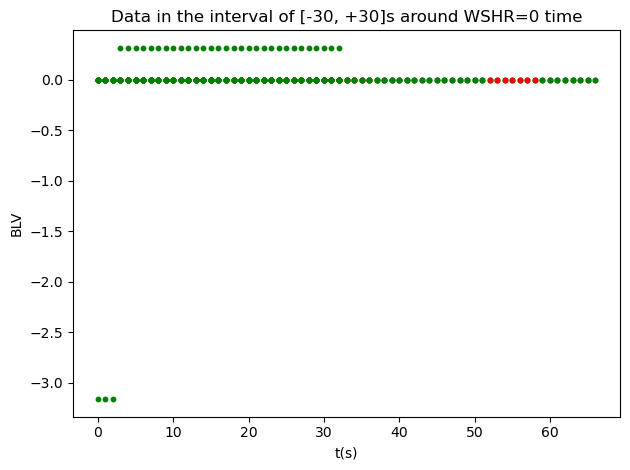

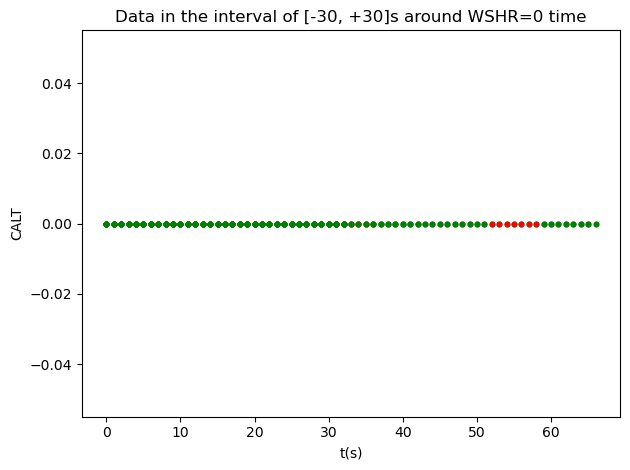

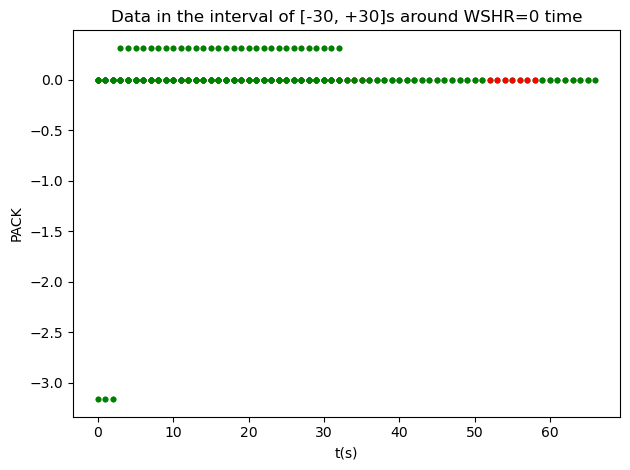

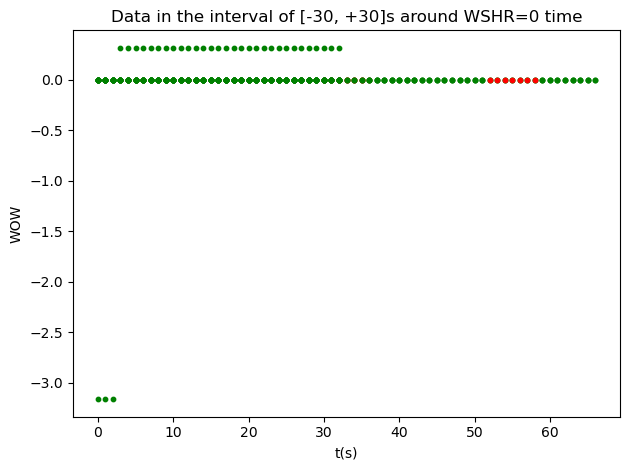

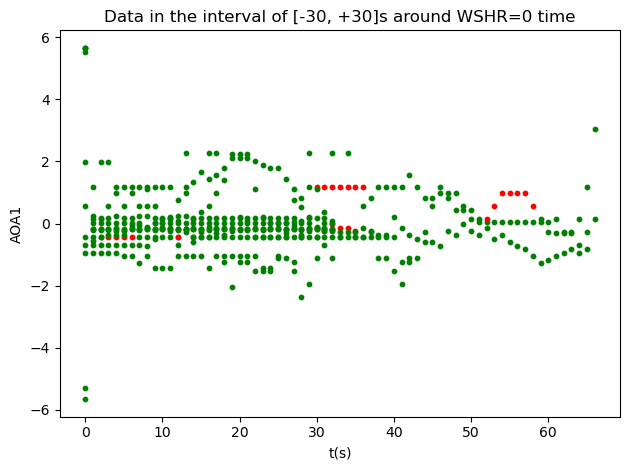

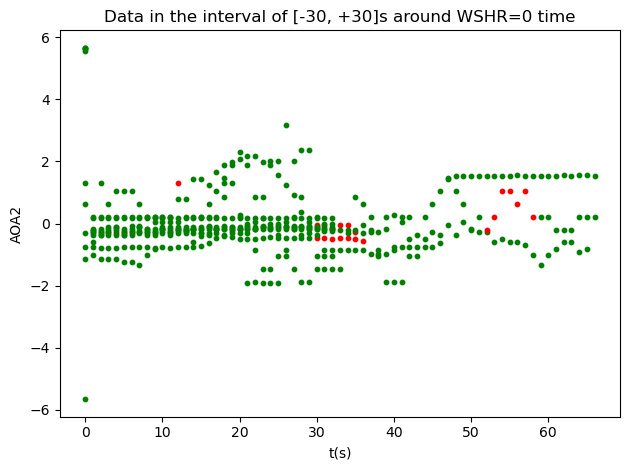

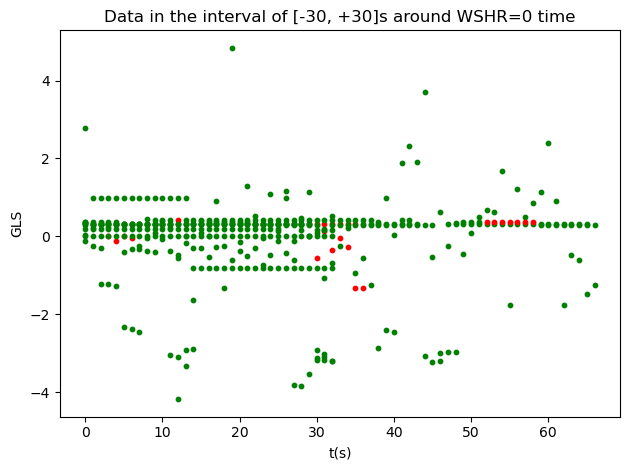

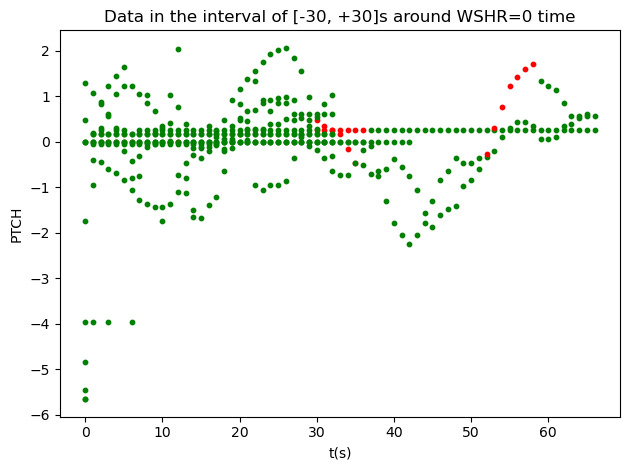

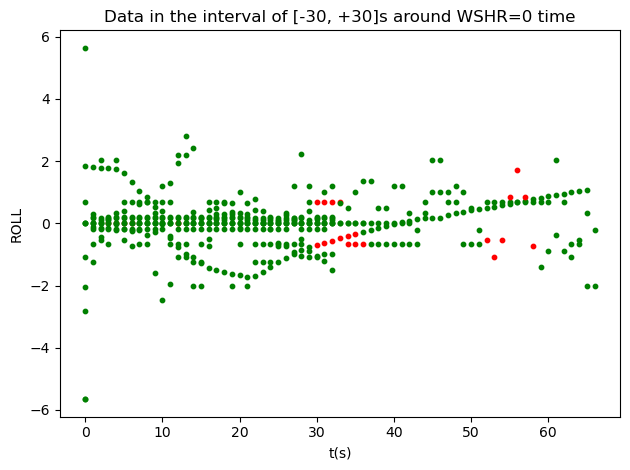

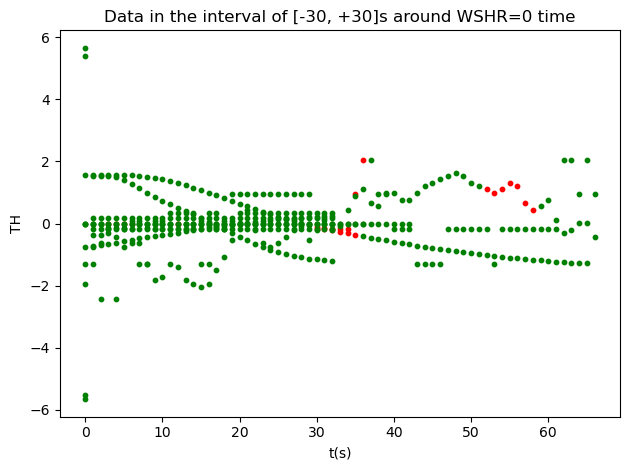

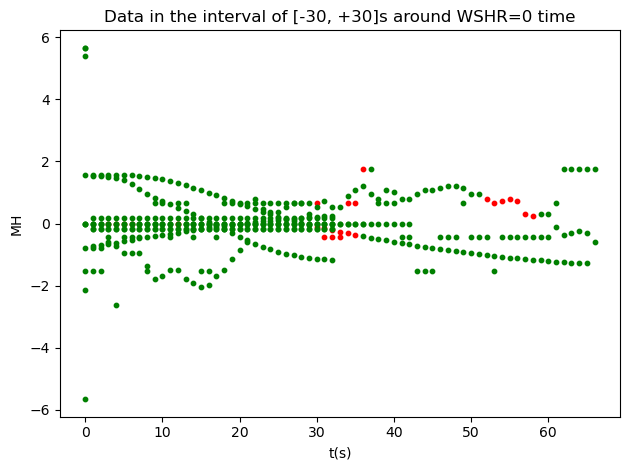

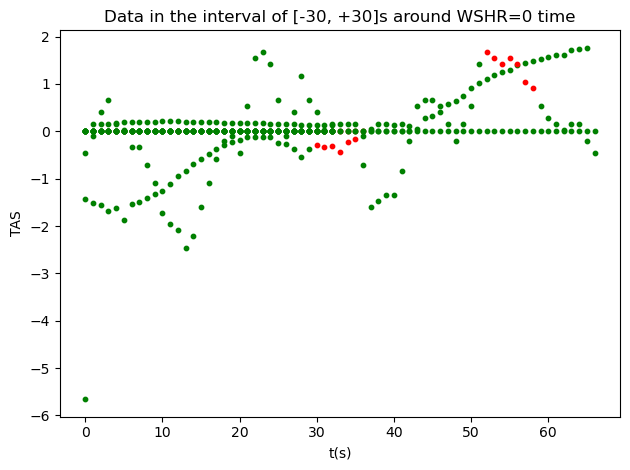

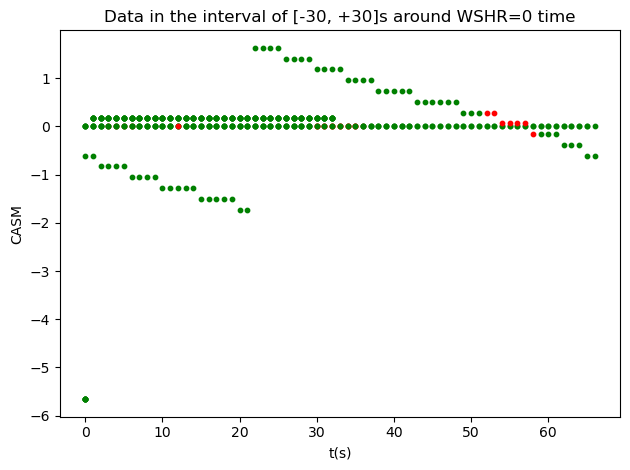

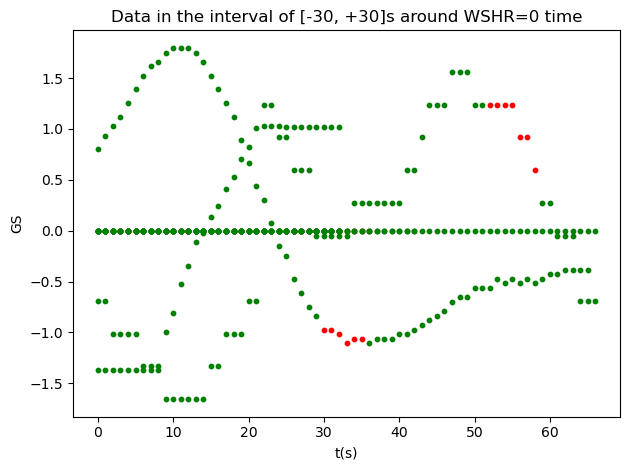

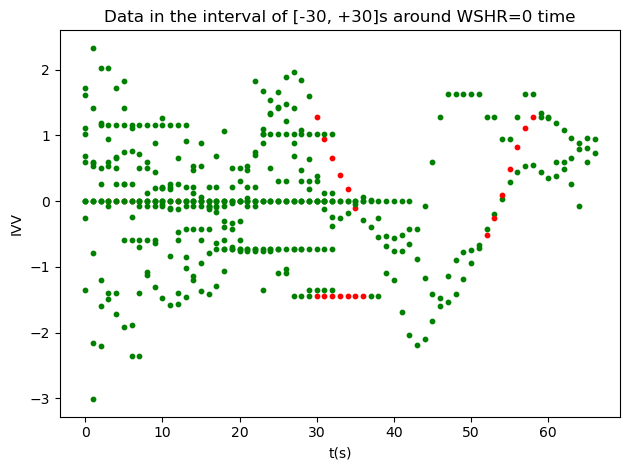

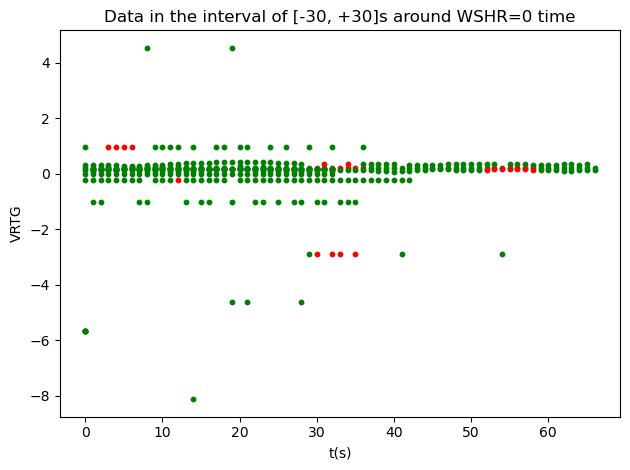

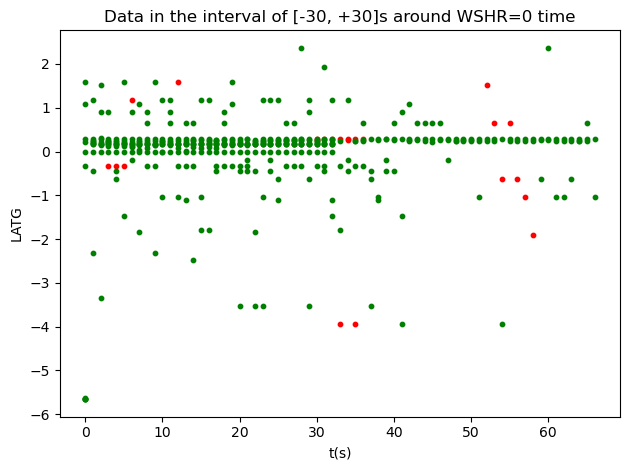

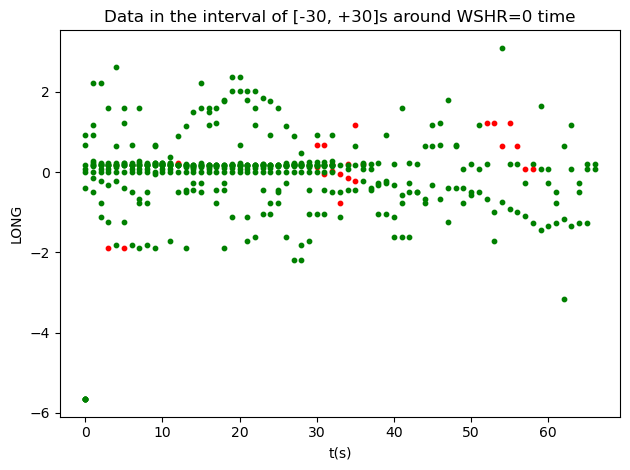

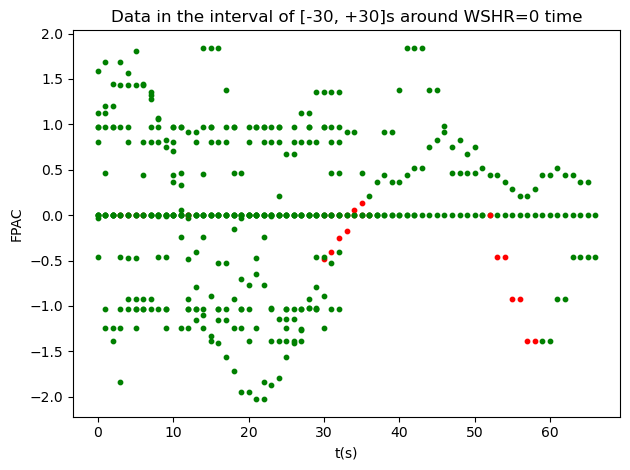

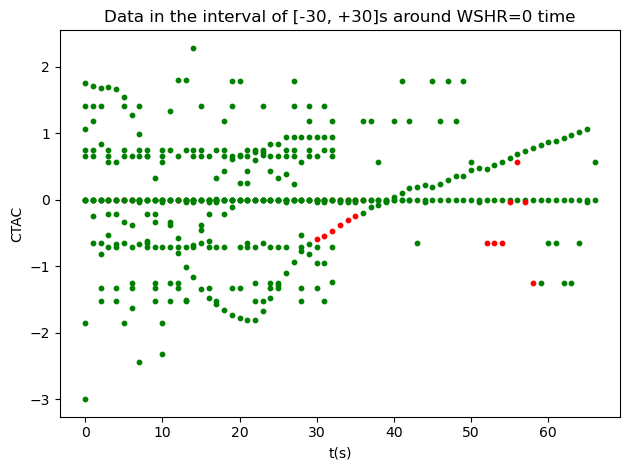

Wind Shear Warns at time [723 724 725 726 727 728 729]
Wind Shear Warns at time [3 4 5 6]
Wind Shear Warns at time [938 939 940 941 942 943]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [12]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]
Wind Shear Warns at time []
Wind Shear Warns at time []


C:\Users\86108\AppData\Local\Temp\ipykernel_58668\1917142417.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_array = np.array(Y_array)


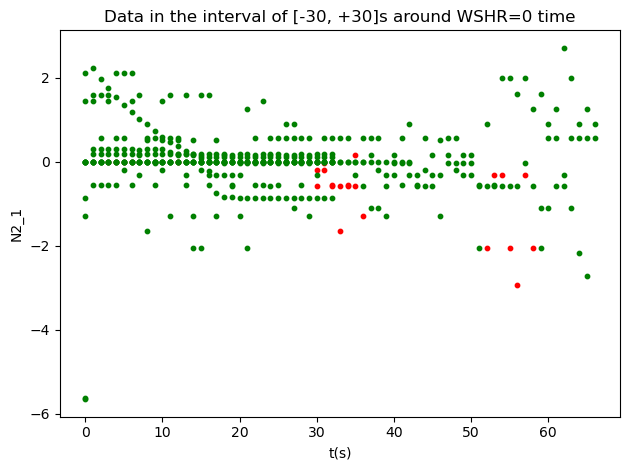

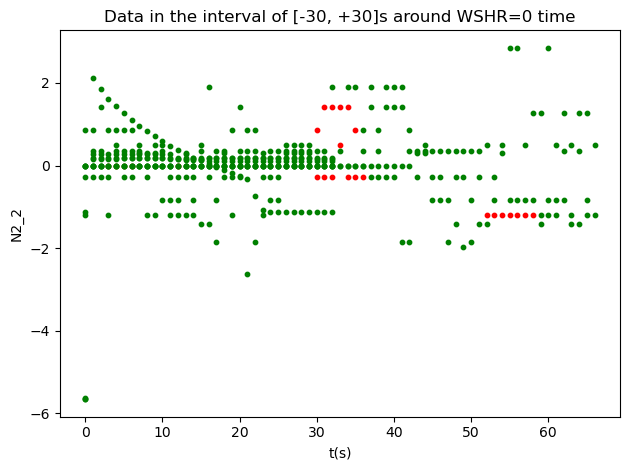

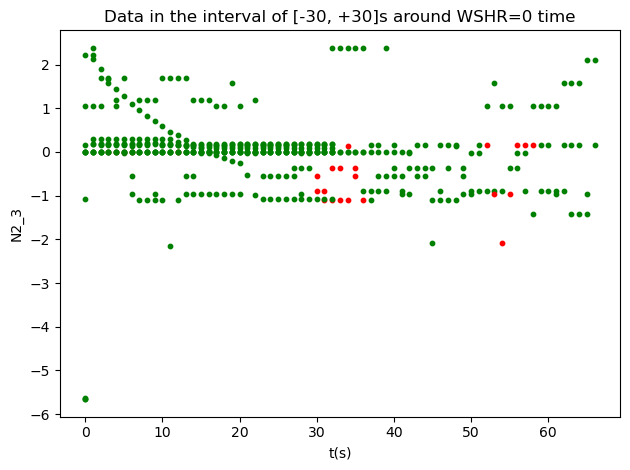

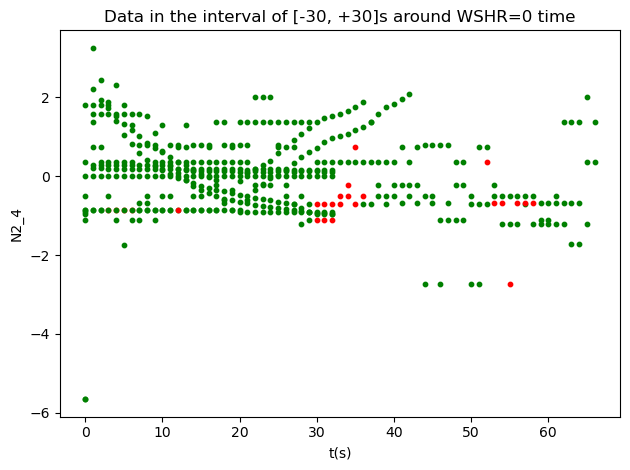

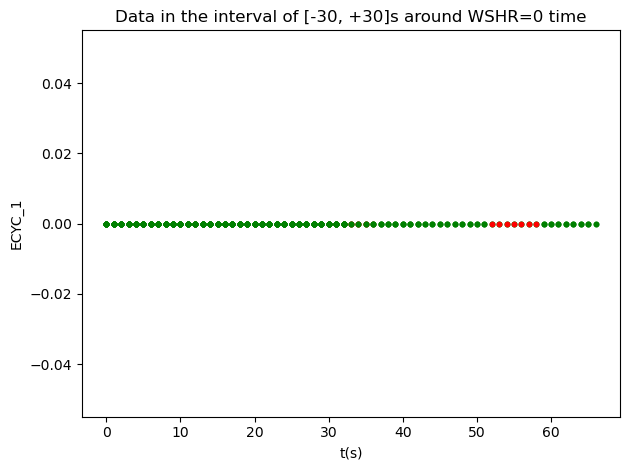

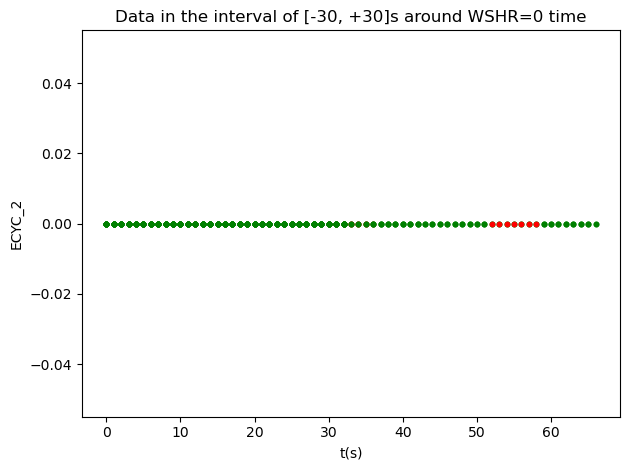

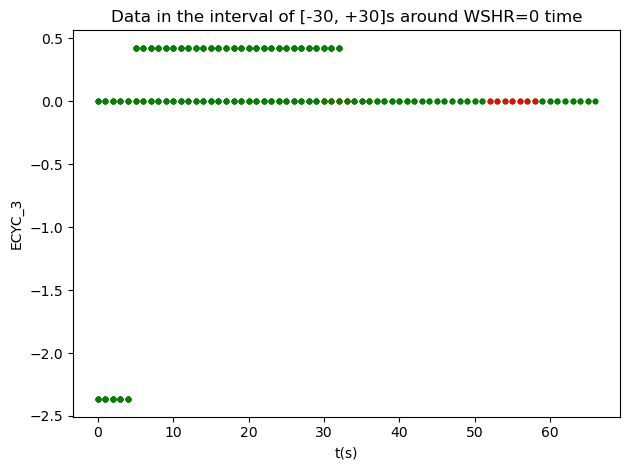

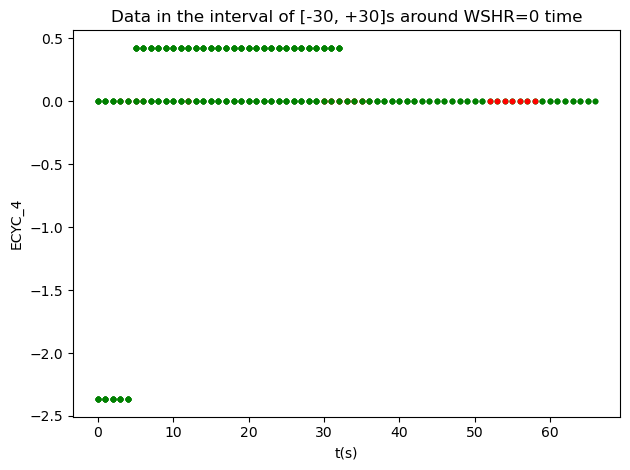

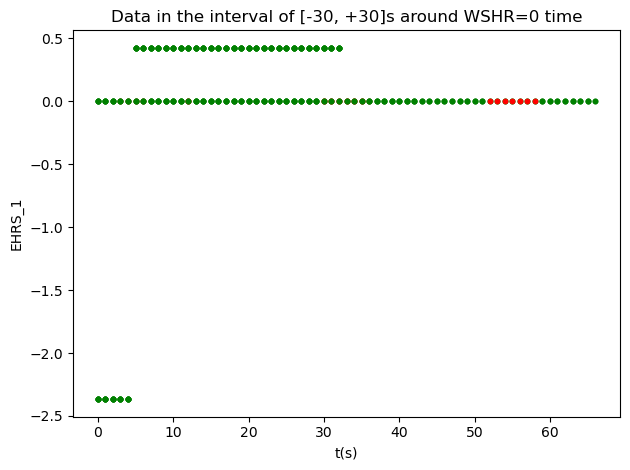

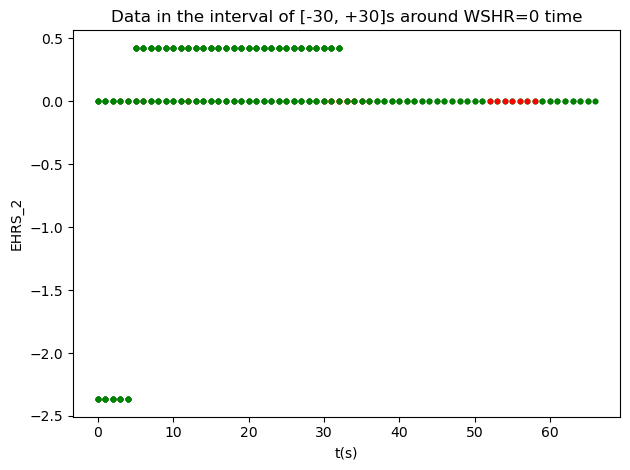

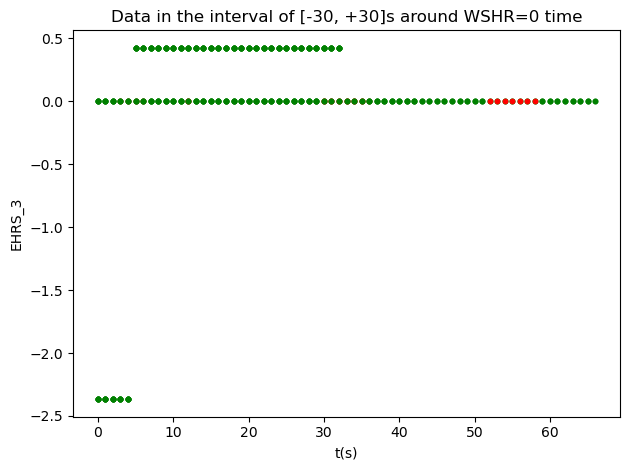

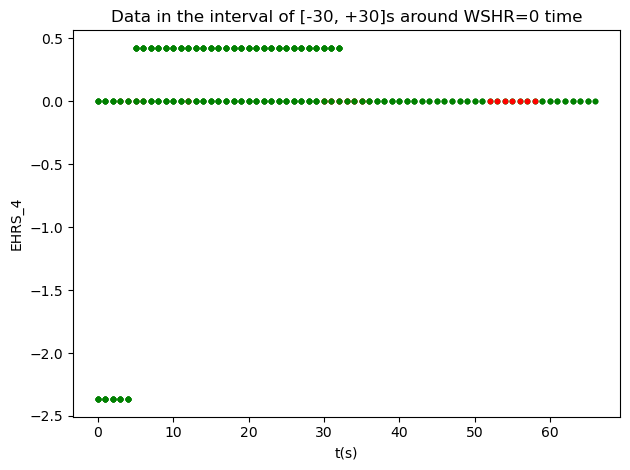

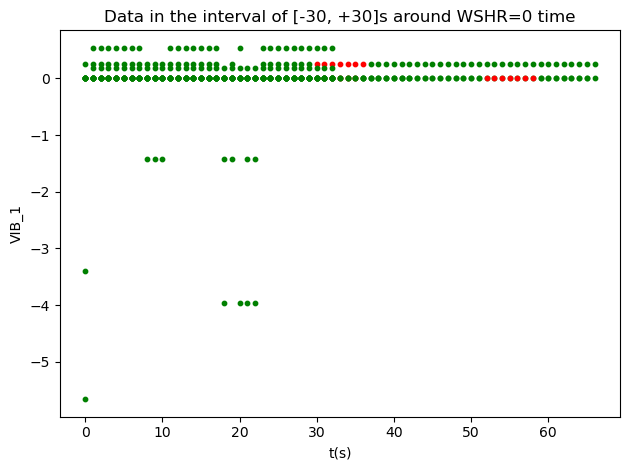

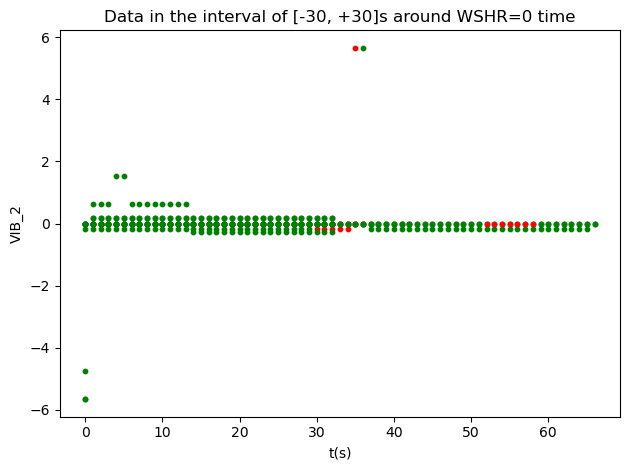

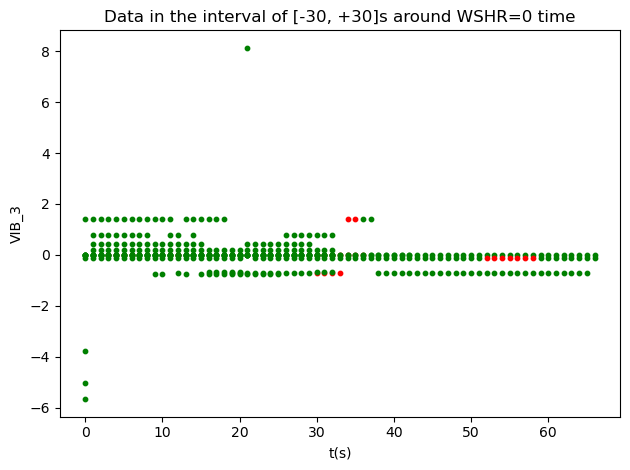

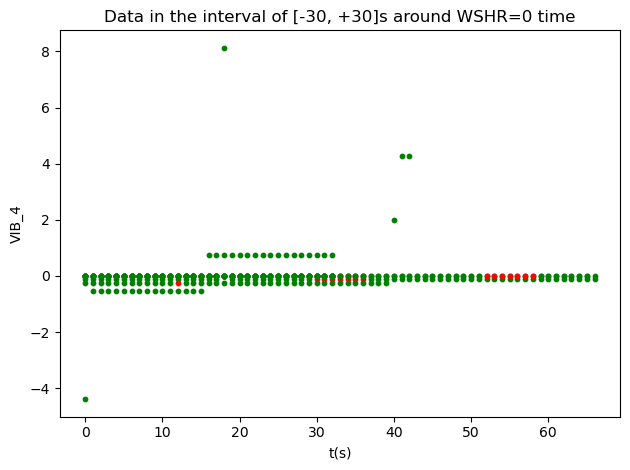

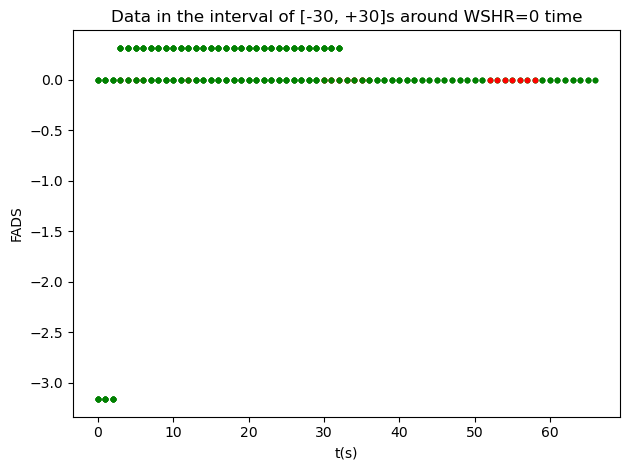

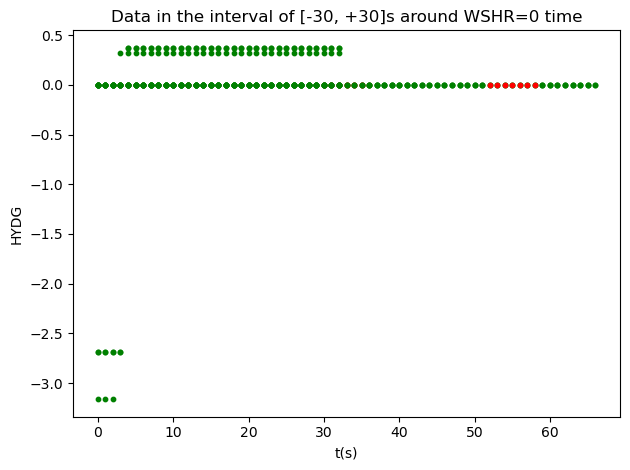

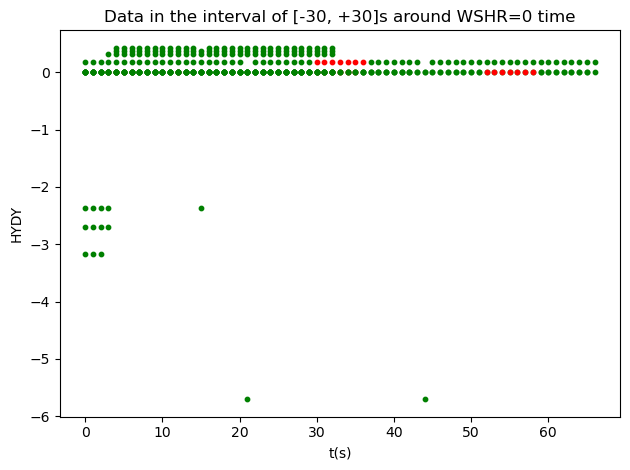

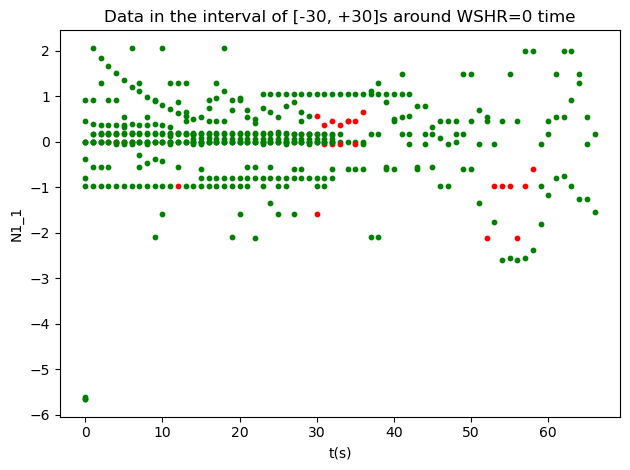

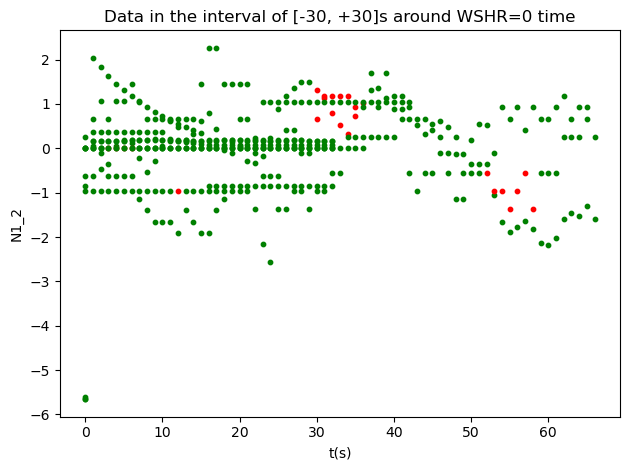

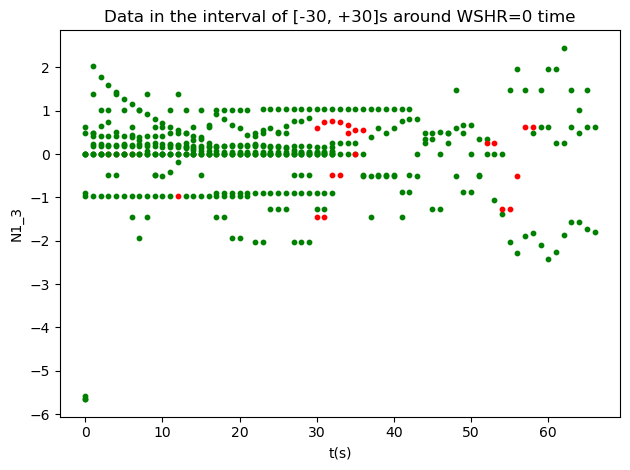

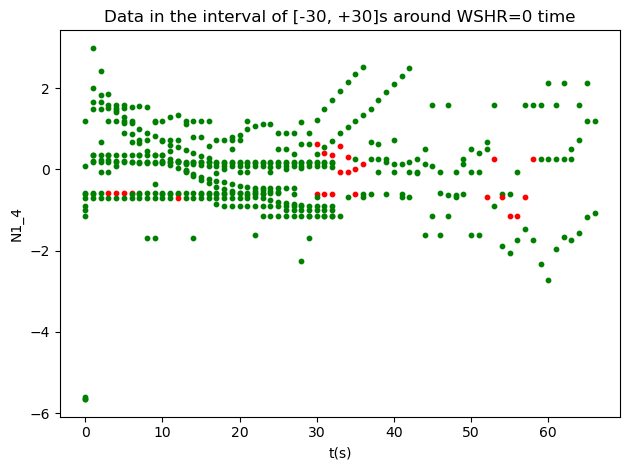

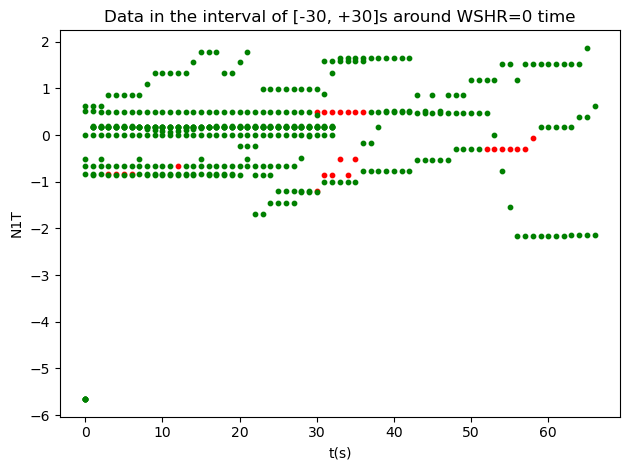

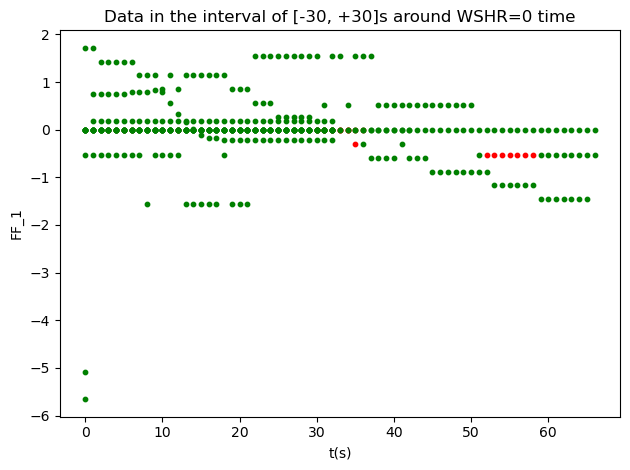

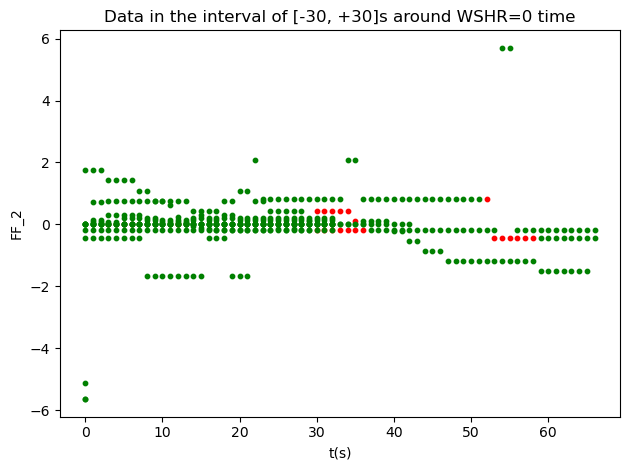

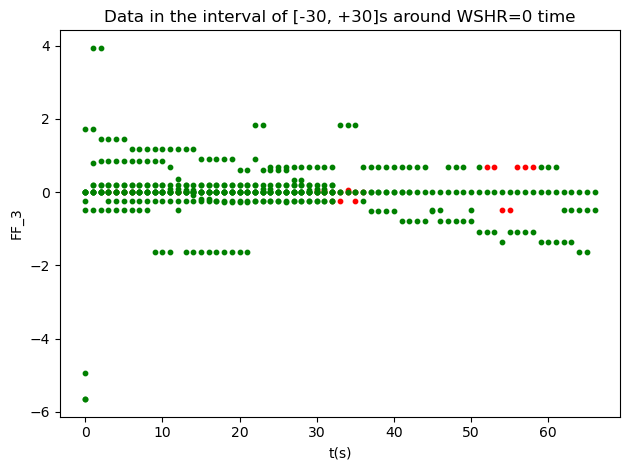

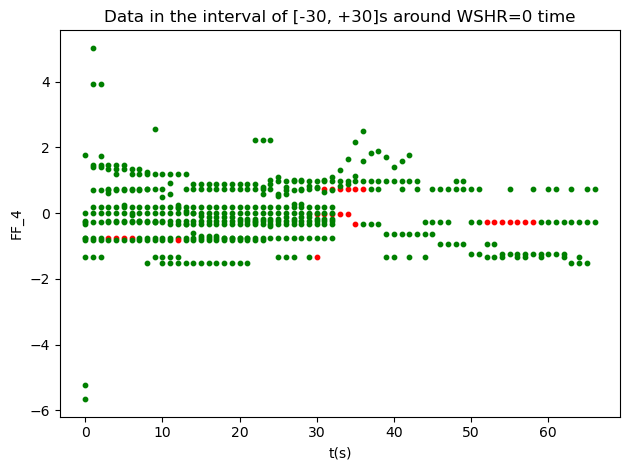

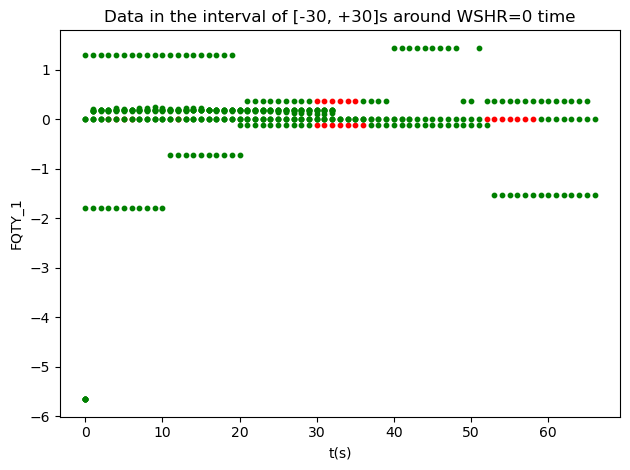

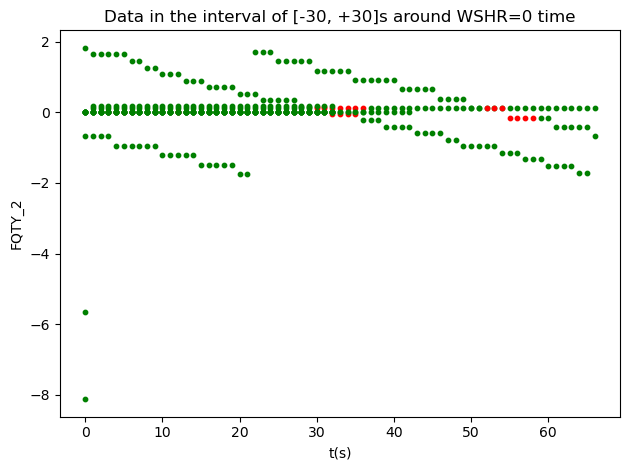

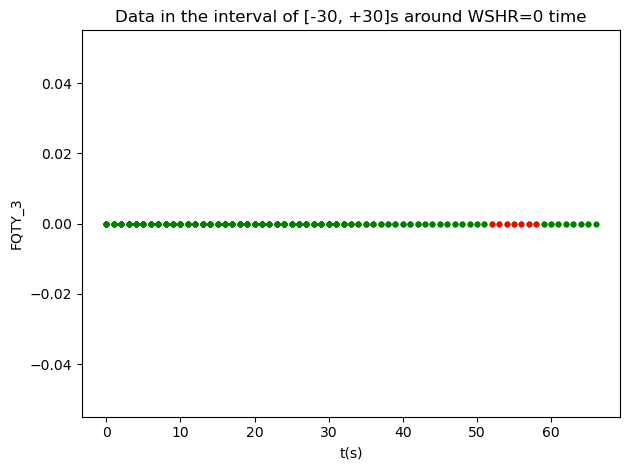

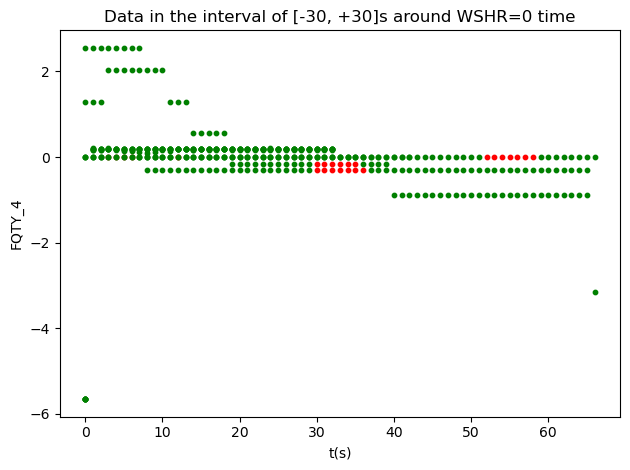

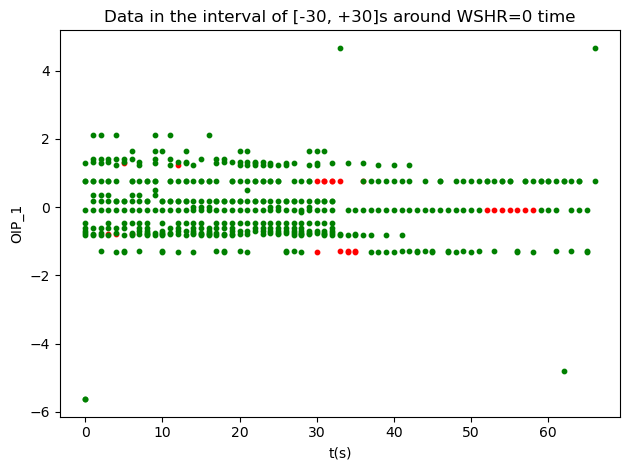

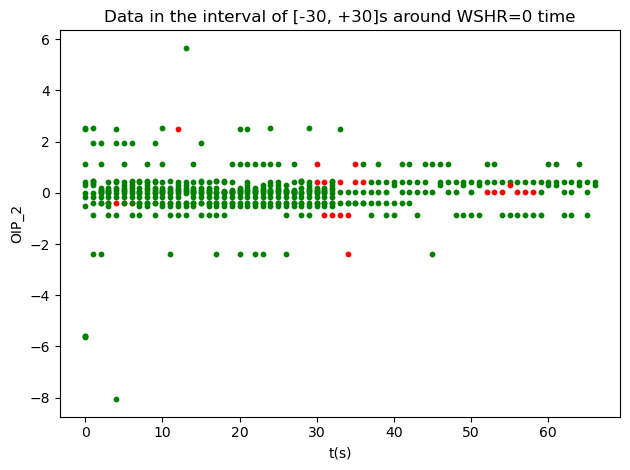

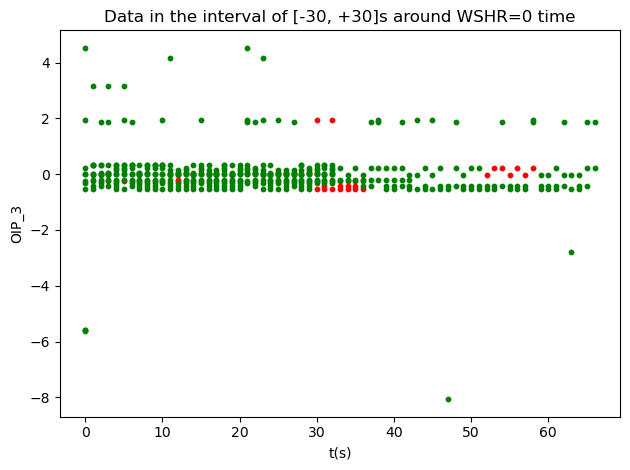

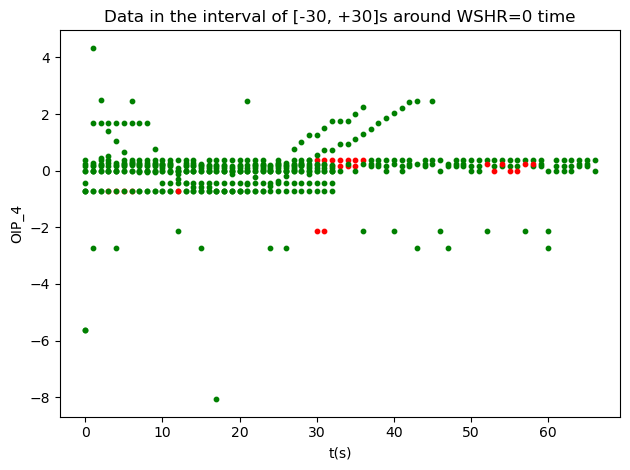

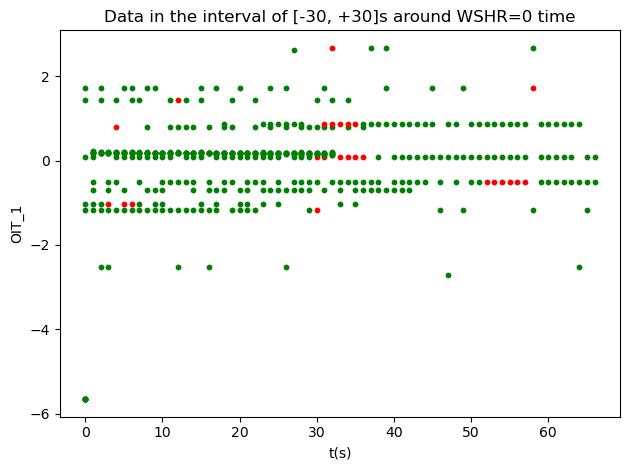

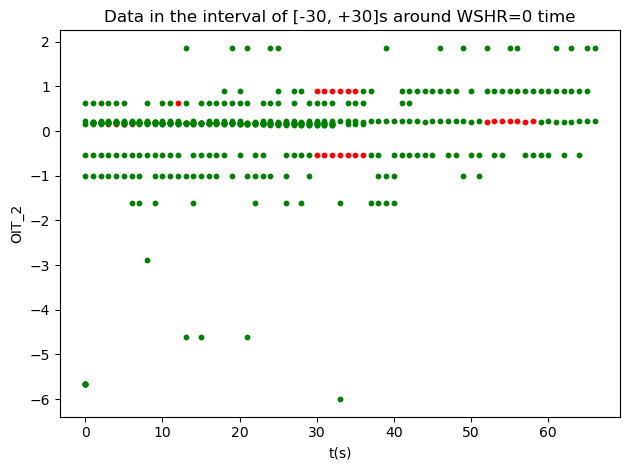

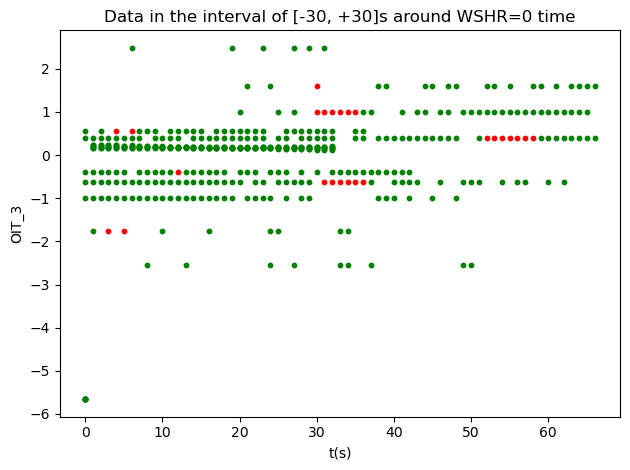

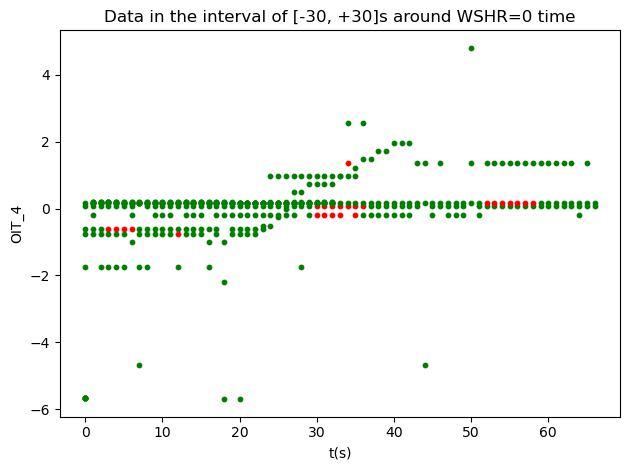

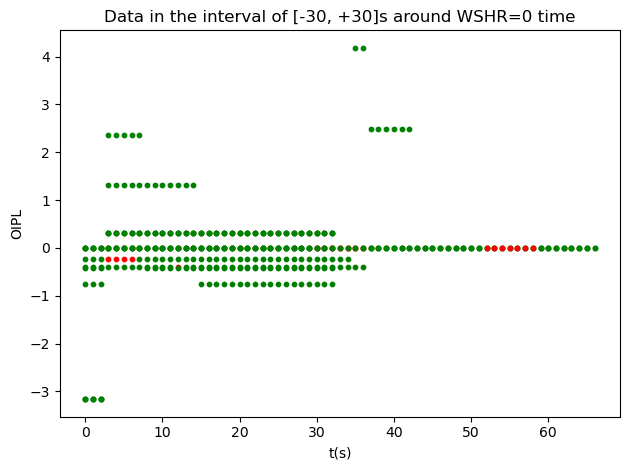

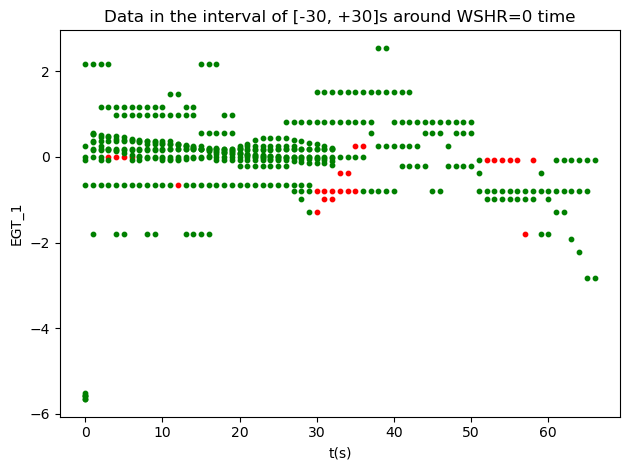

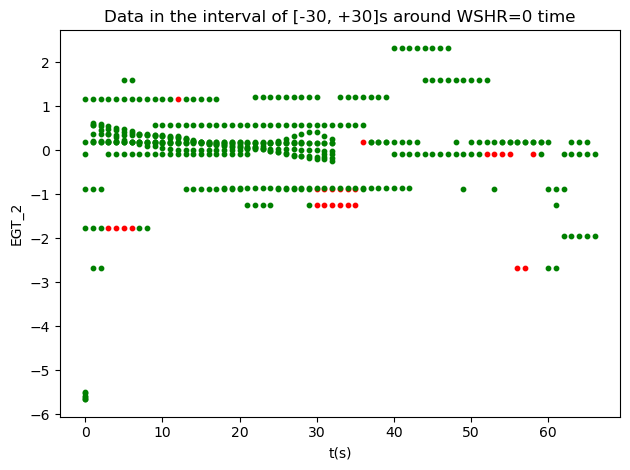

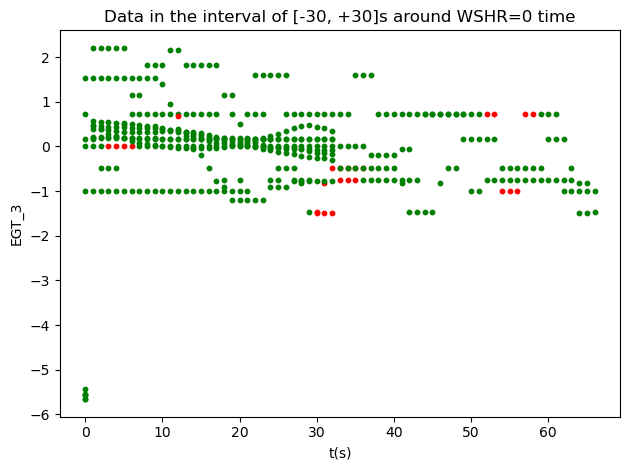

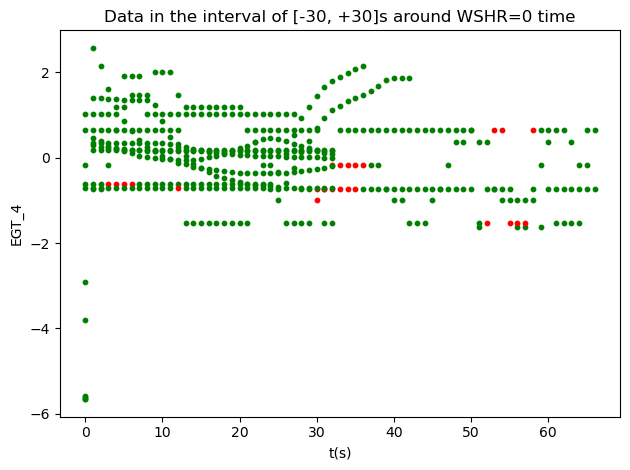

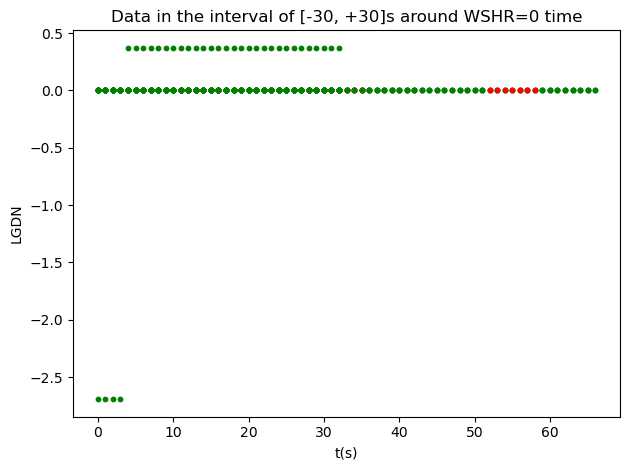

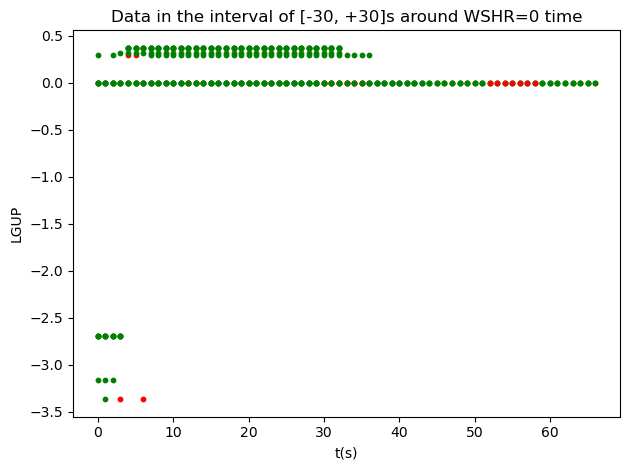

Wind Shear Warns at time [723 724 725 726 727 728 729]
Wind Shear Warns at time [3 4 5 6]
Wind Shear Warns at time [938 939 940 941 942 943]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [12]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]
Wind Shear Warns at time []
Wind Shear Warns at time []


C:\Users\86108\AppData\Local\Temp\ipykernel_58668\1917142417.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_array = np.array(Y_array)


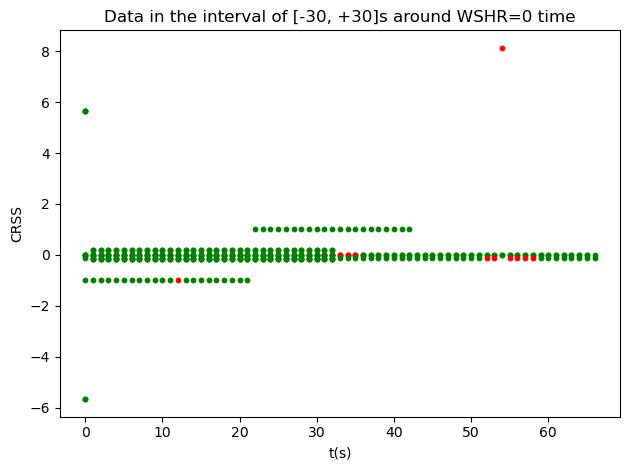

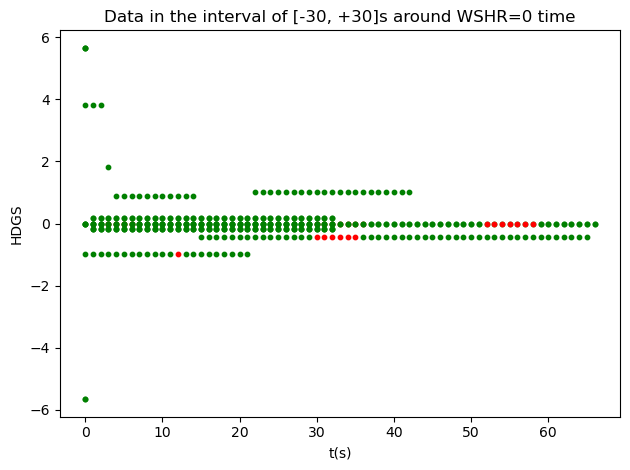

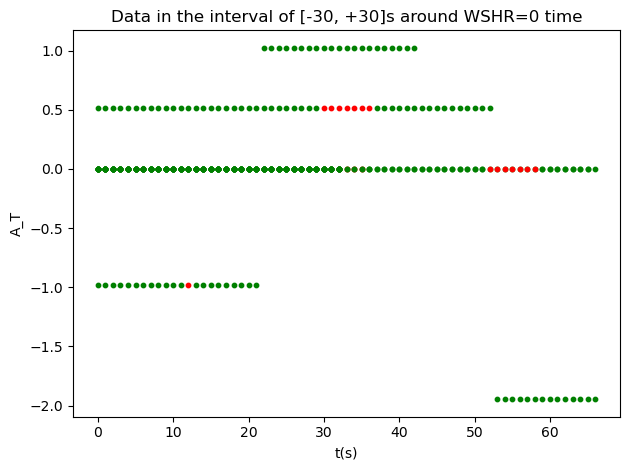

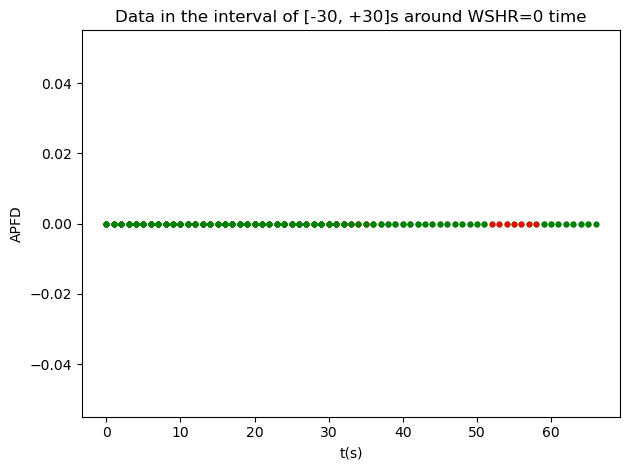

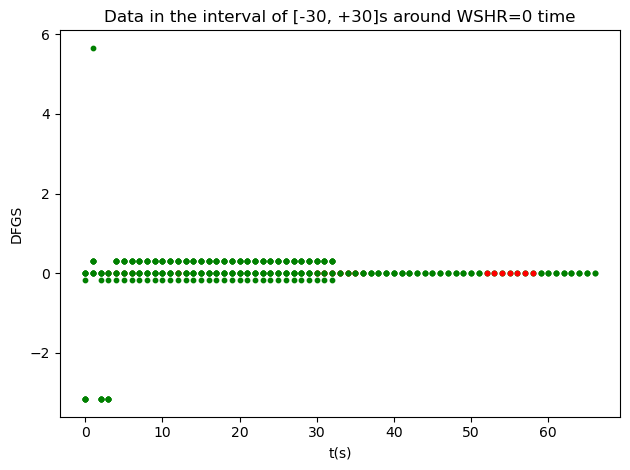

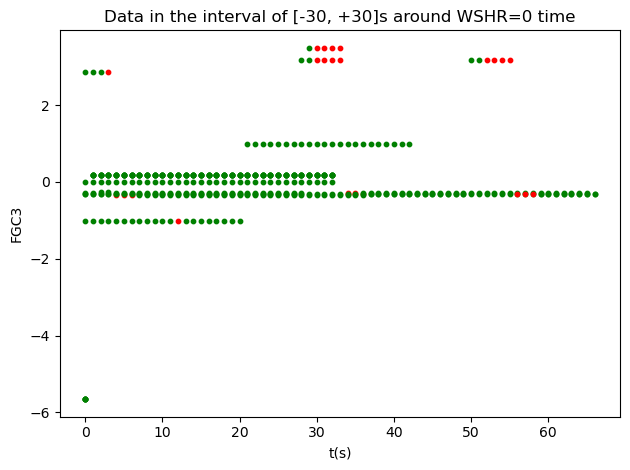

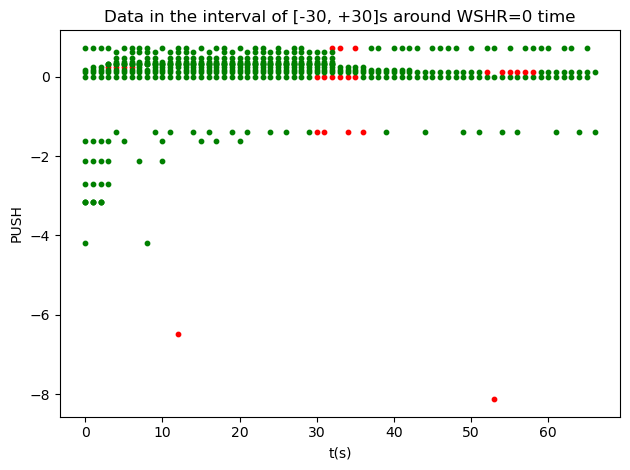

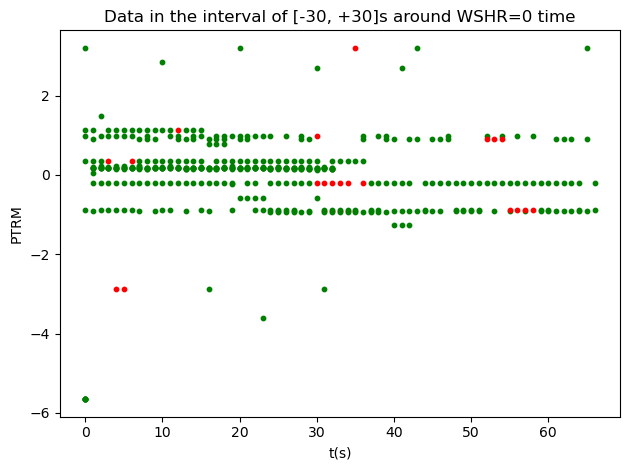

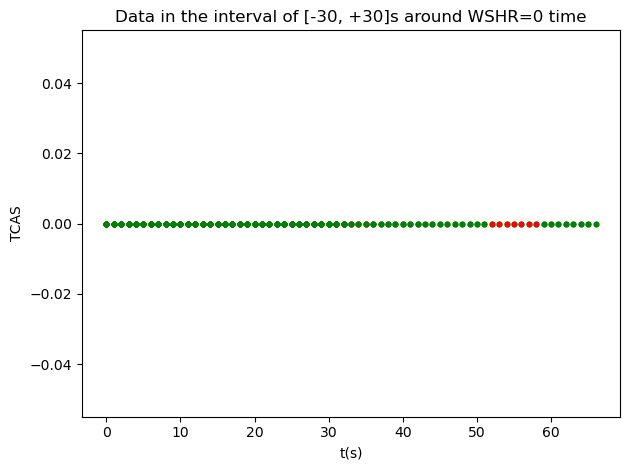

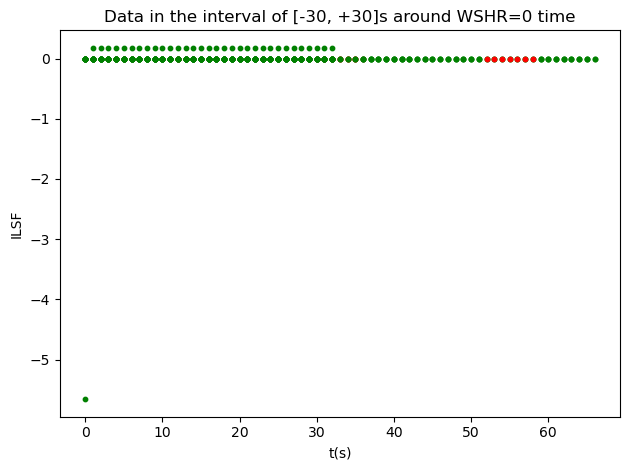

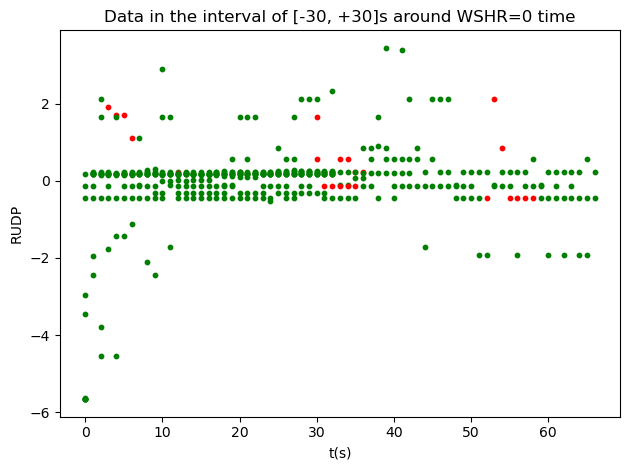

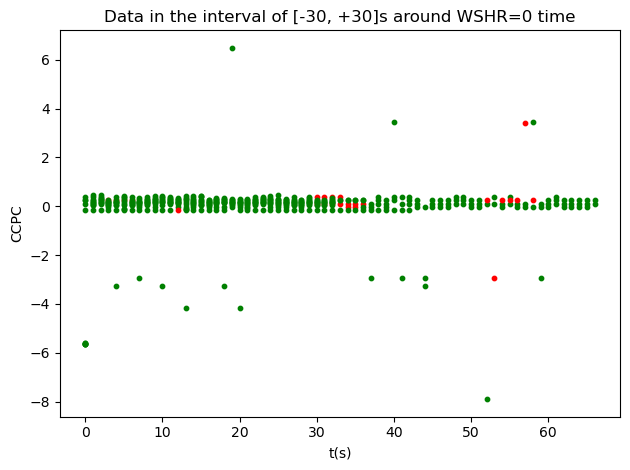

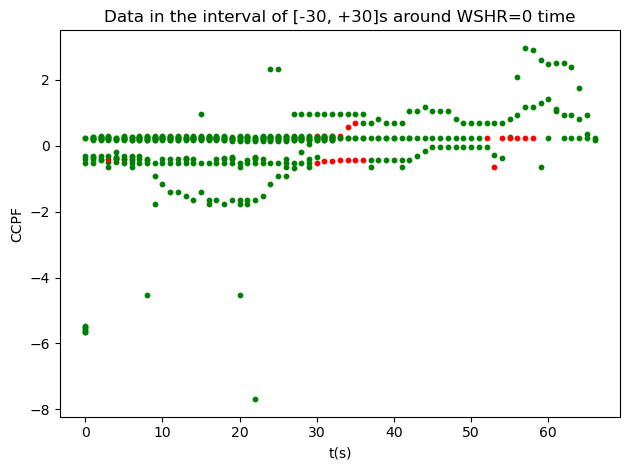

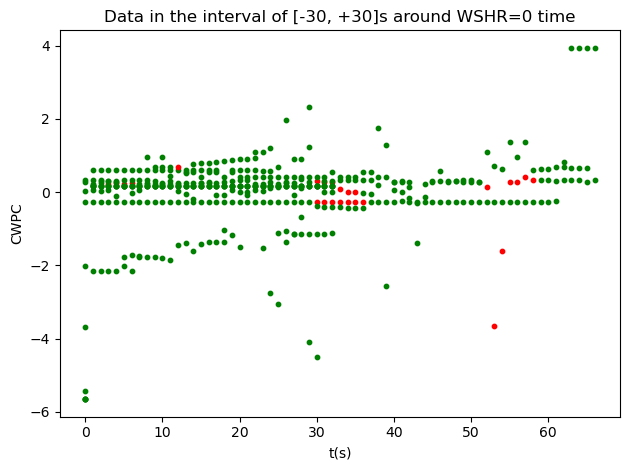

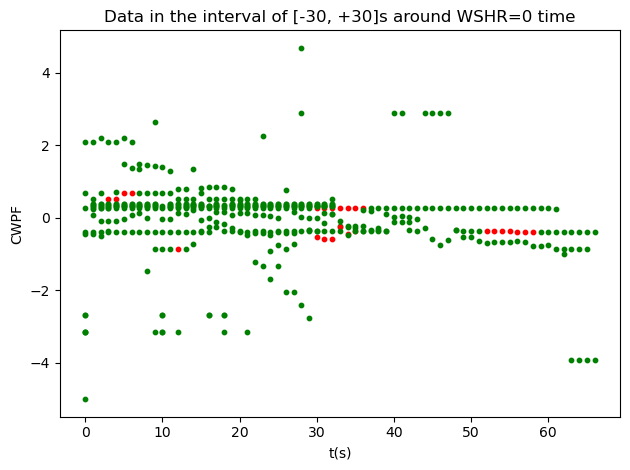

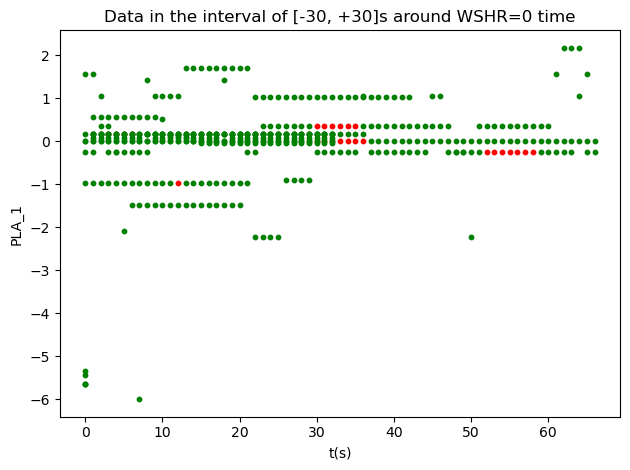

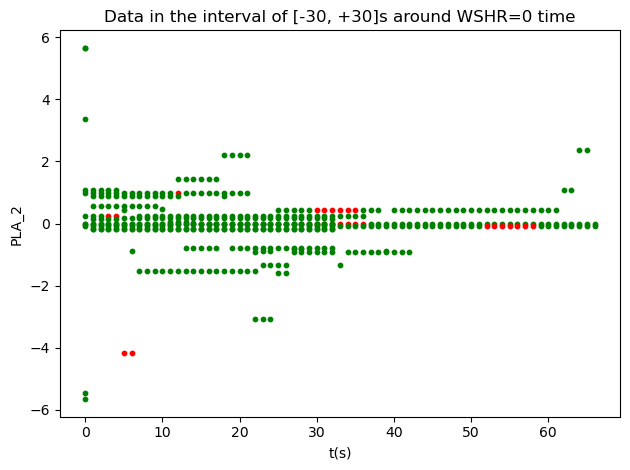

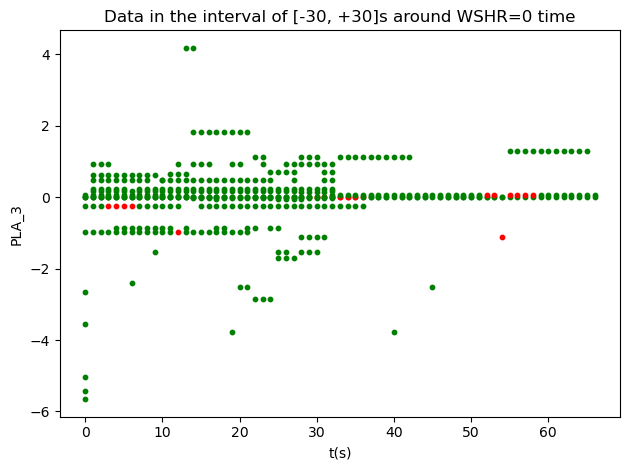

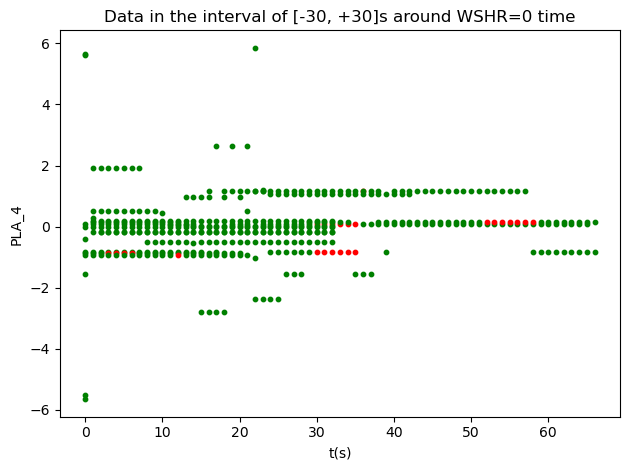

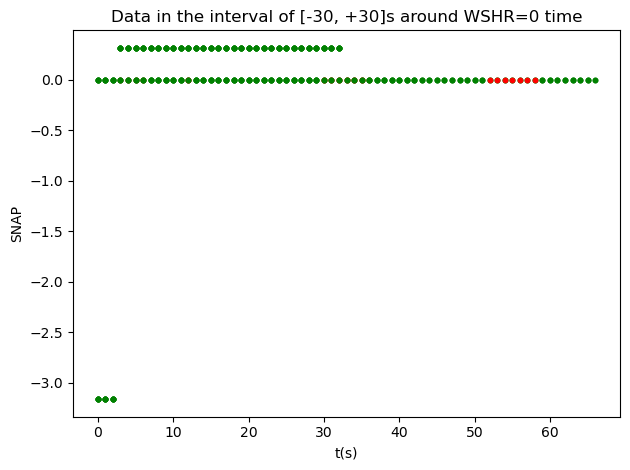

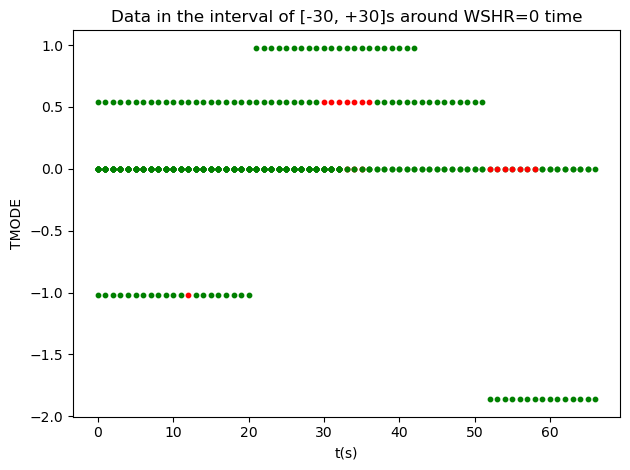

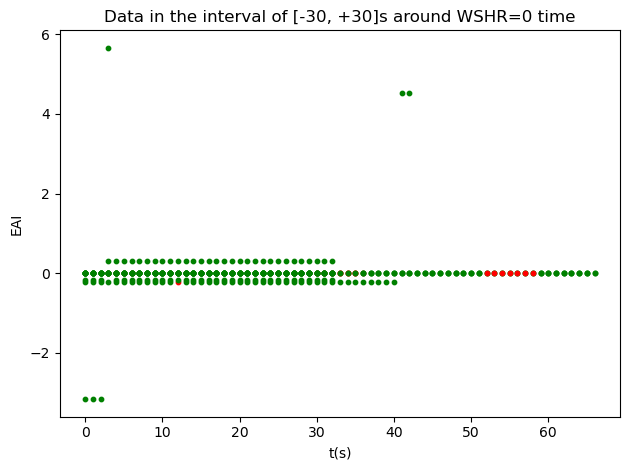

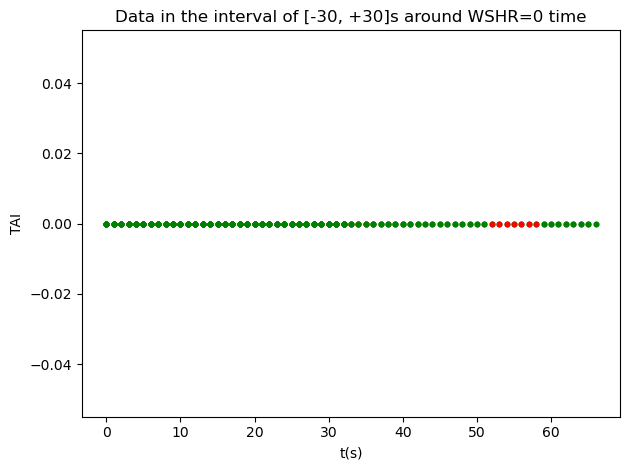

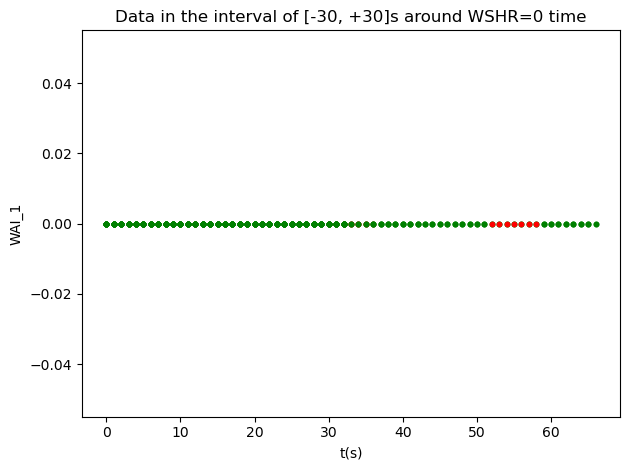

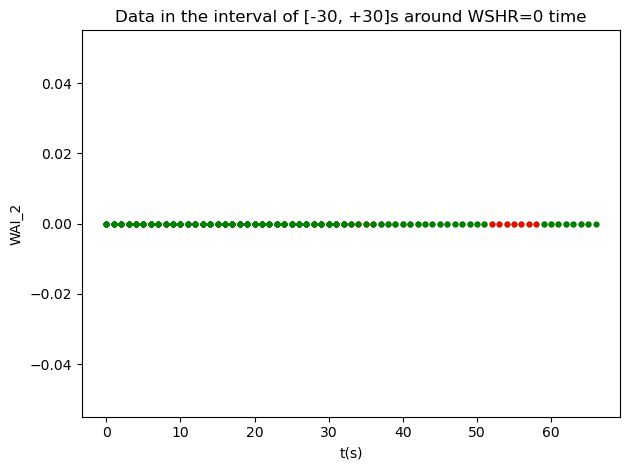

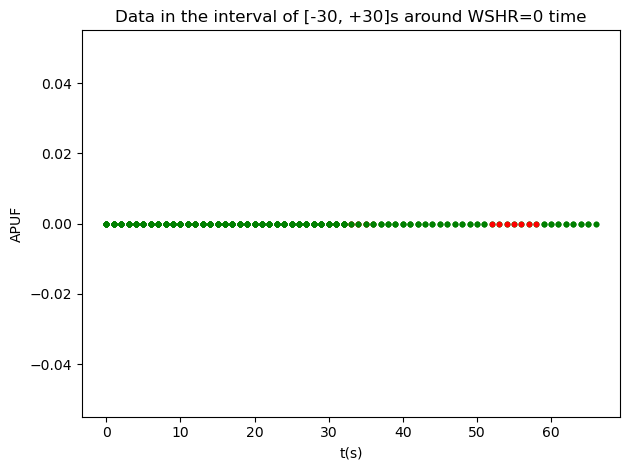

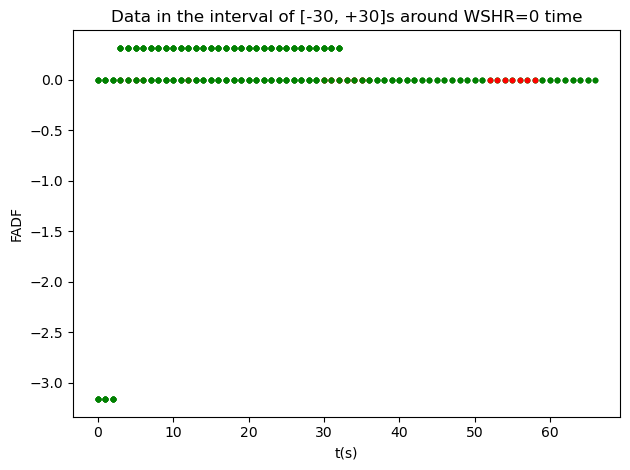

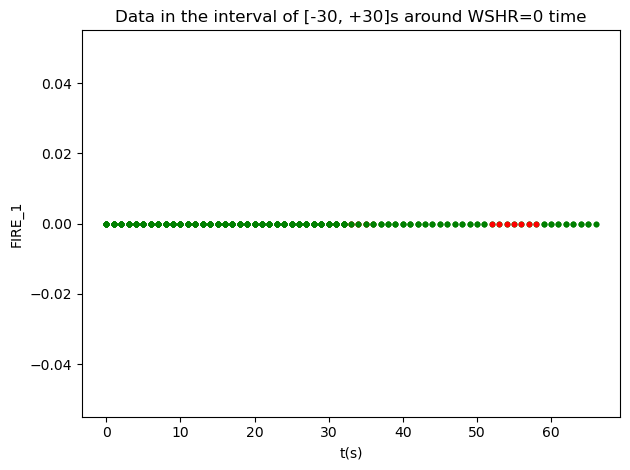

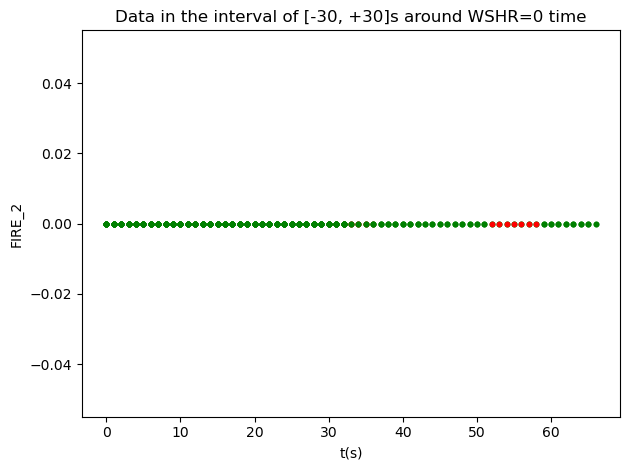

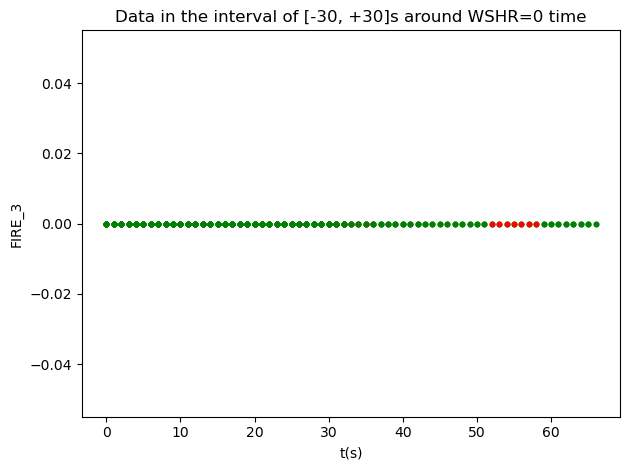

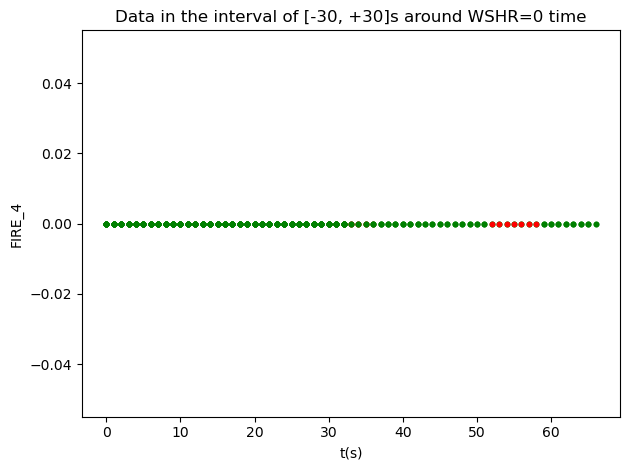

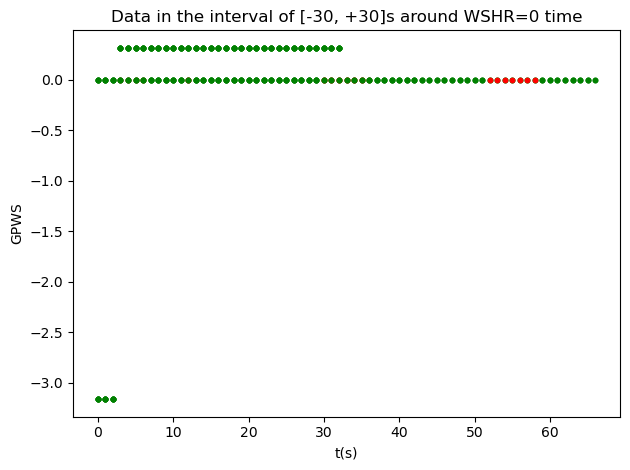

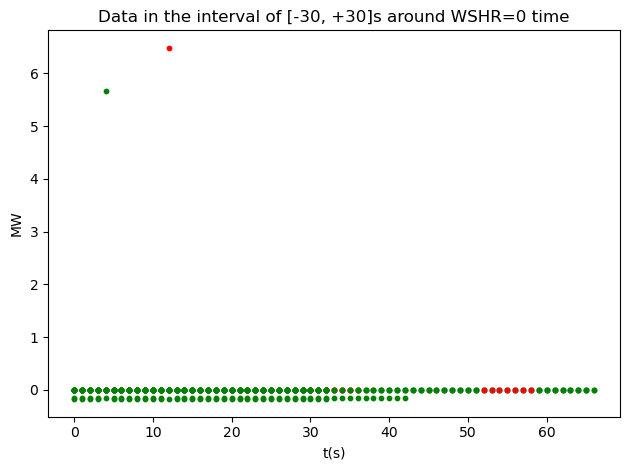

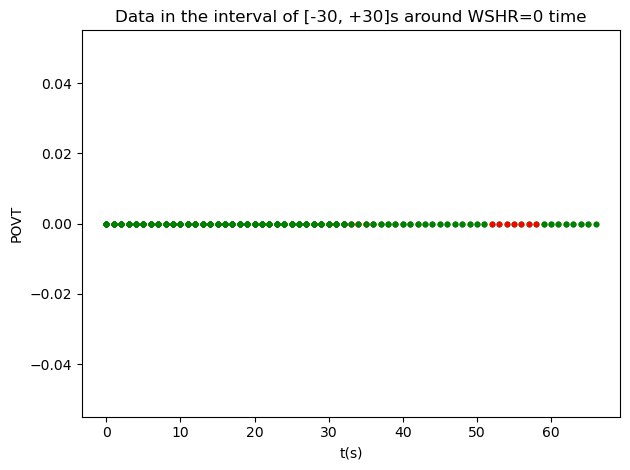

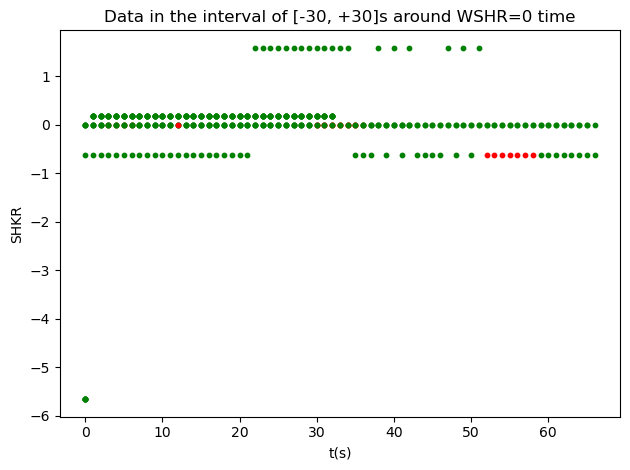

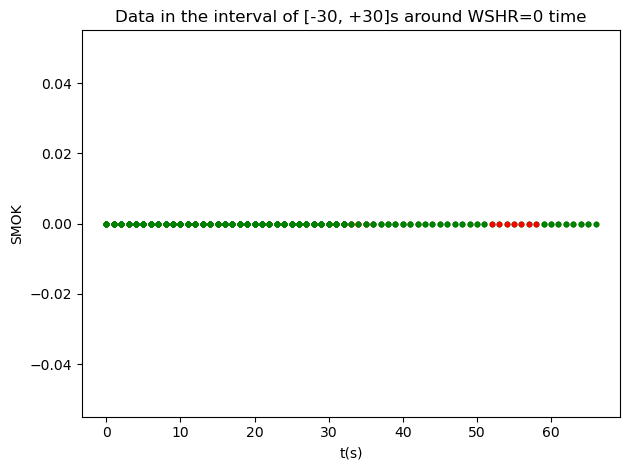

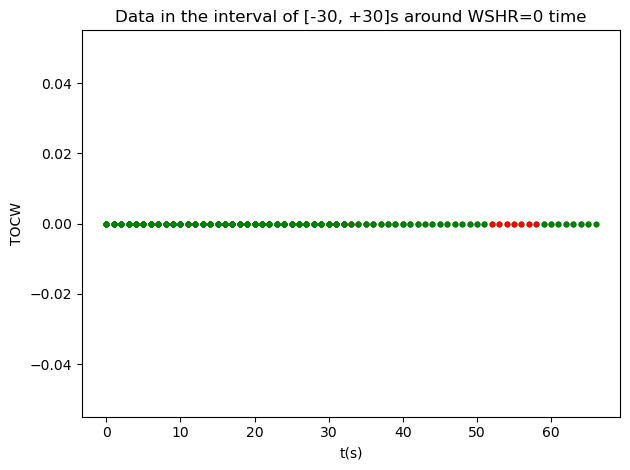

Wind Shear Warns at time [723 724 725 726 727 728 729]
Wind Shear Warns at time [3 4 5 6]
Wind Shear Warns at time [938 939 940 941 942 943]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [12]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]
Wind Shear Warns at time []
Wind Shear Warns at time []


C:\Users\86108\AppData\Local\Temp\ipykernel_58668\1917142417.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_array = np.array(Y_array)


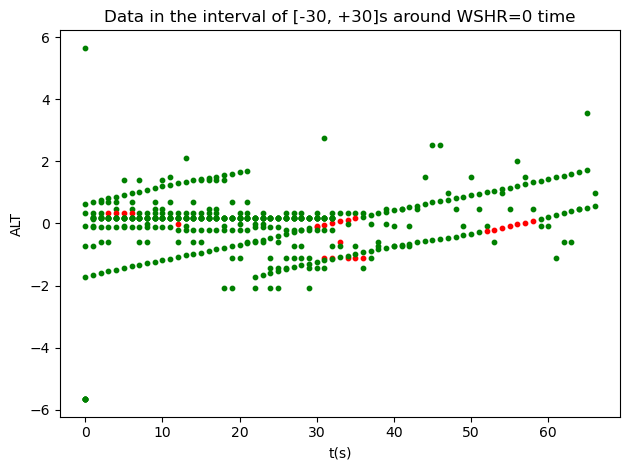

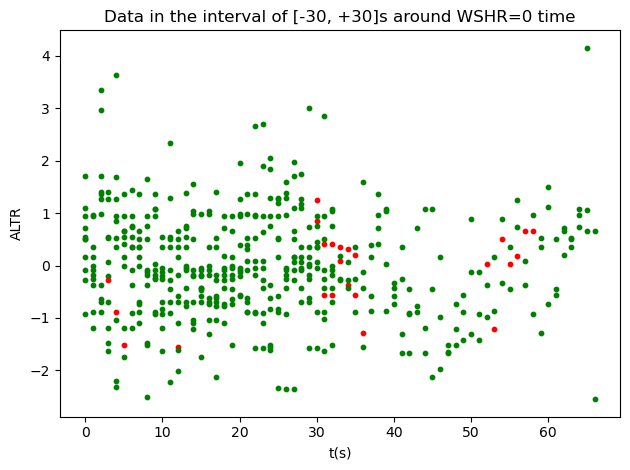

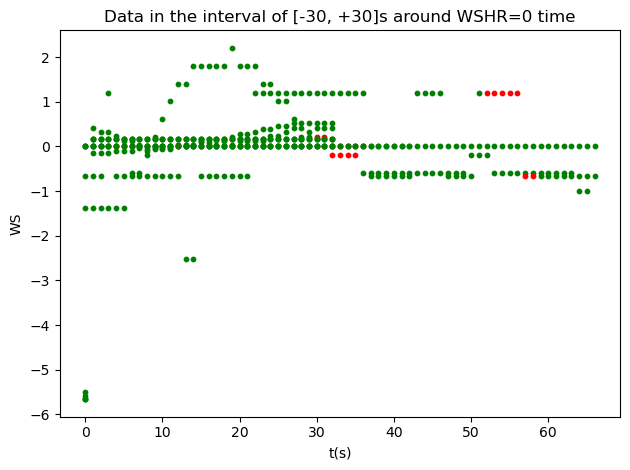

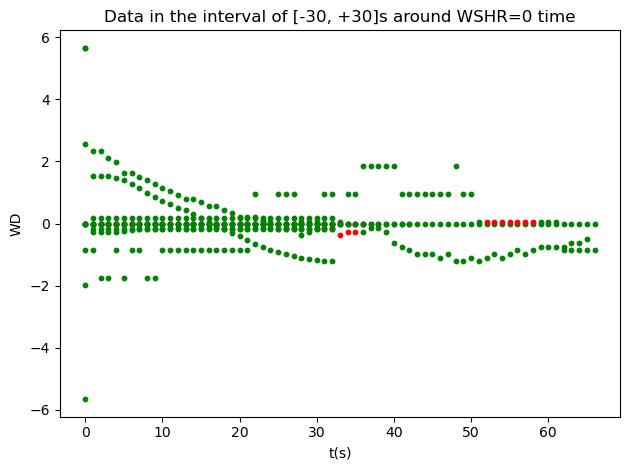

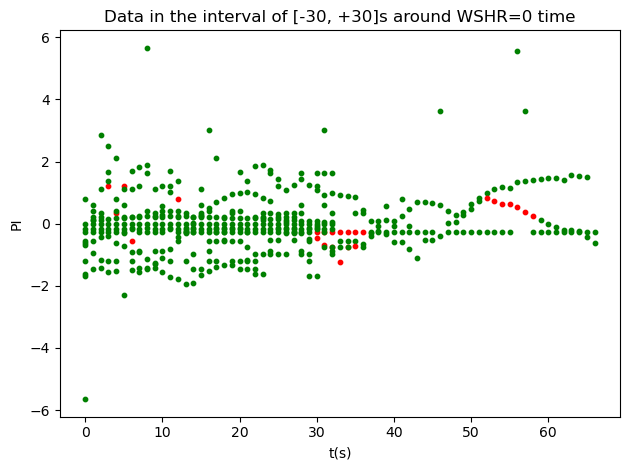

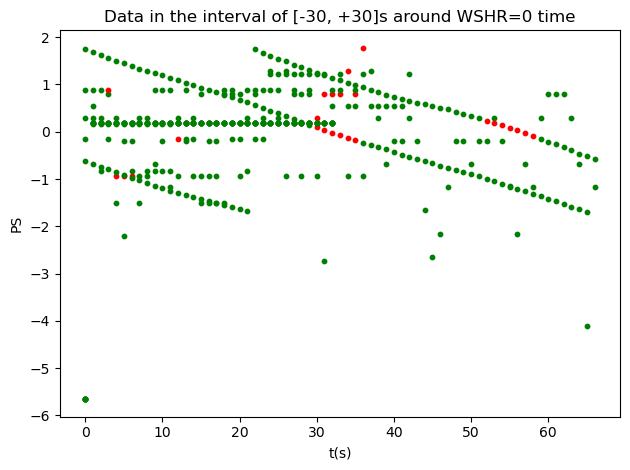

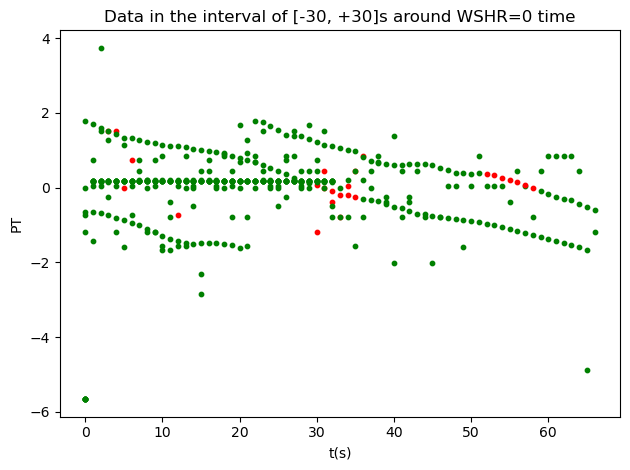

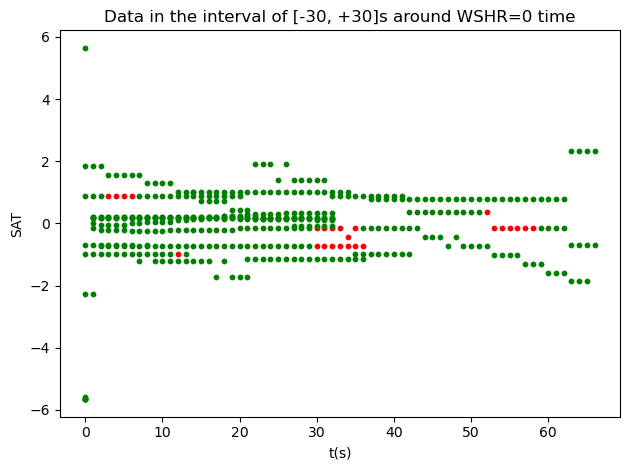

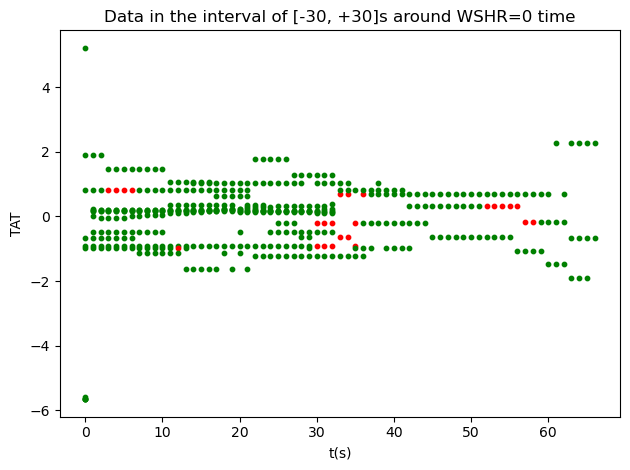

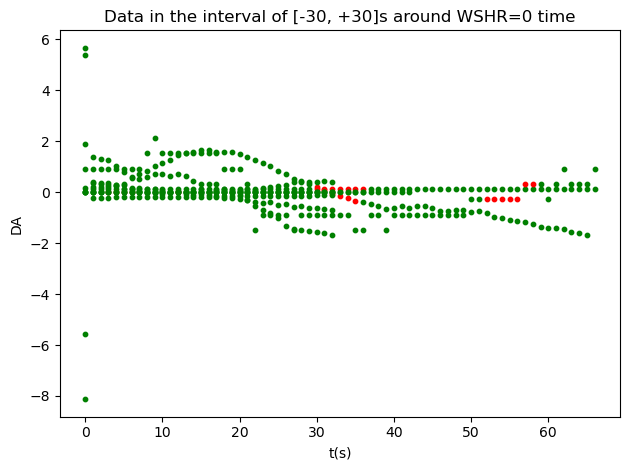

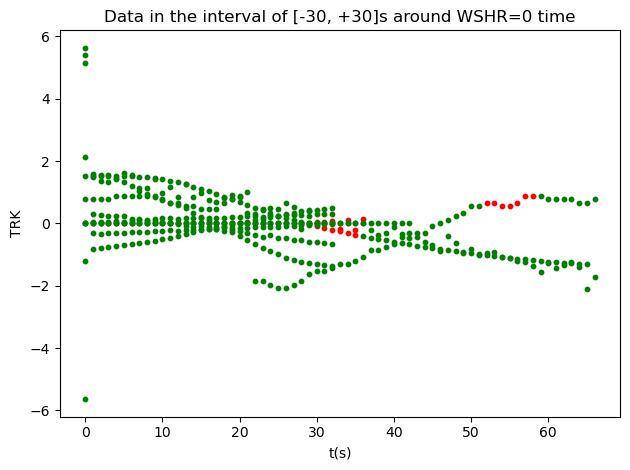

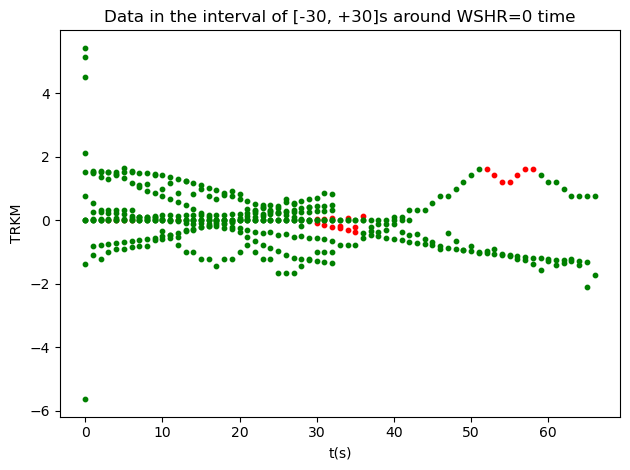

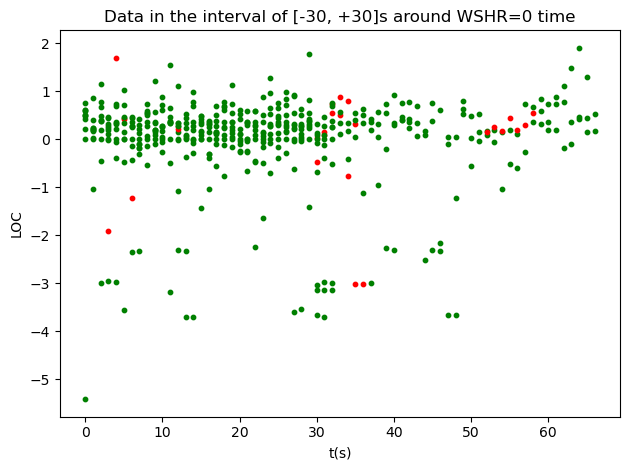

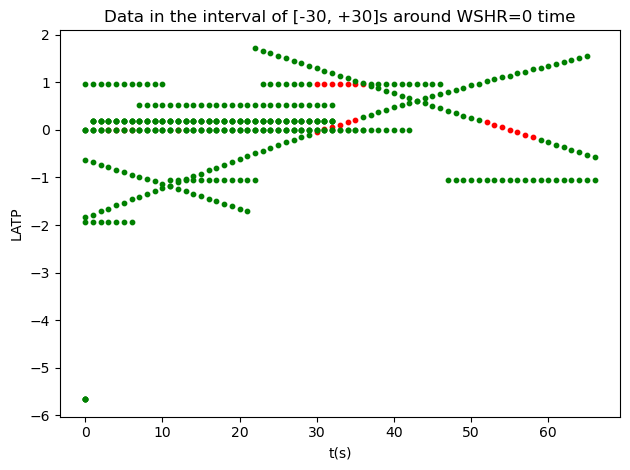

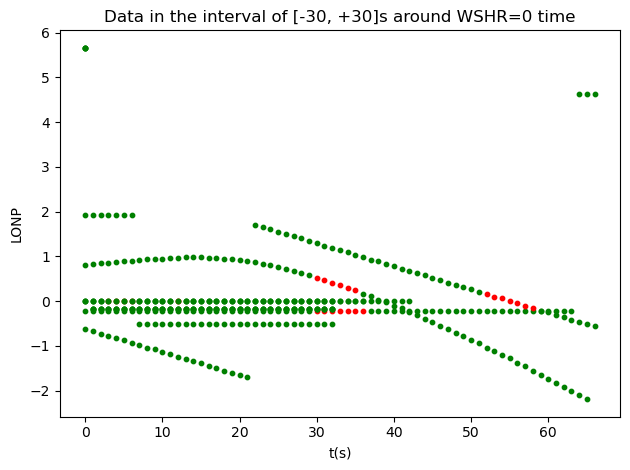

Wind Shear Warns at time [723 724 725 726 727 728 729]
Wind Shear Warns at time [3 4 5 6]
Wind Shear Warns at time [938 939 940 941 942 943]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [12]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]
Wind Shear Warns at time []
Wind Shear Warns at time []


C:\Users\86108\AppData\Local\Temp\ipykernel_58668\1917142417.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_array = np.array(Y_array)


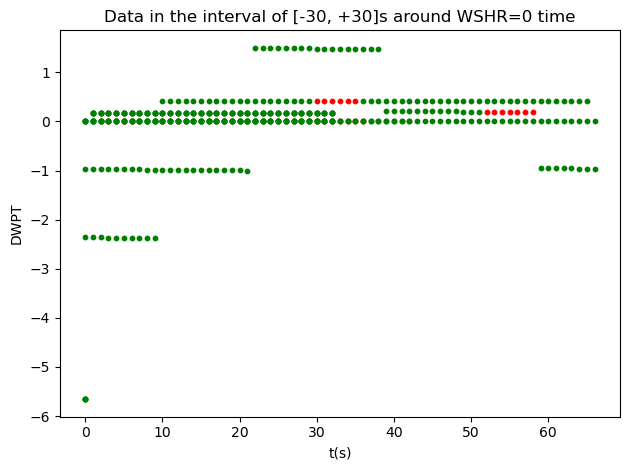

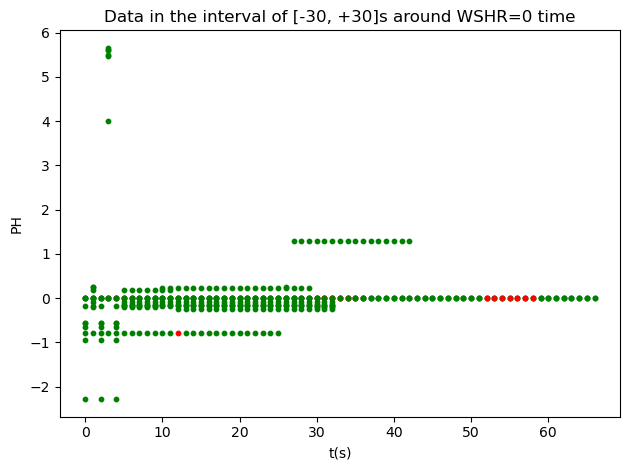

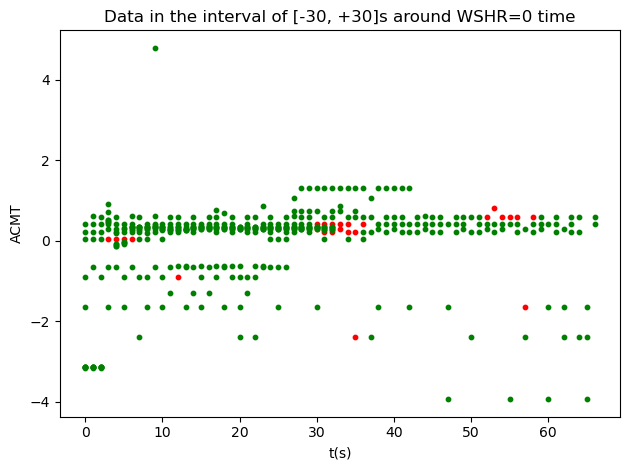

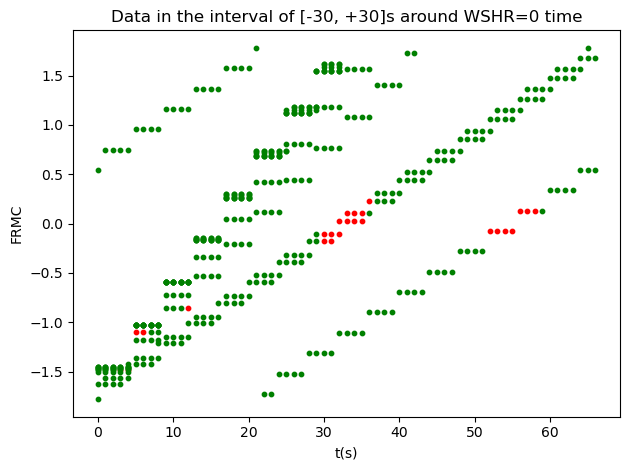

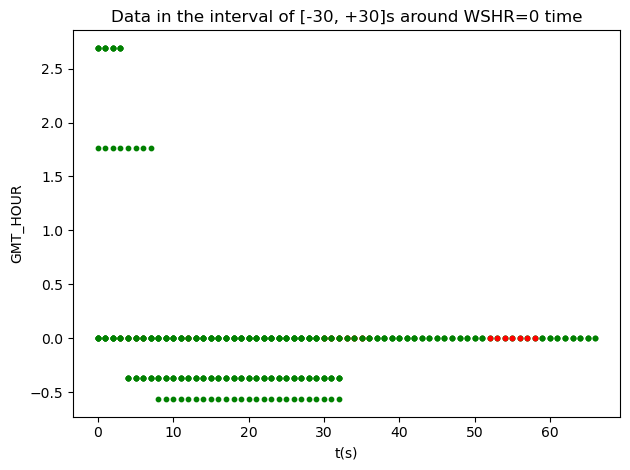

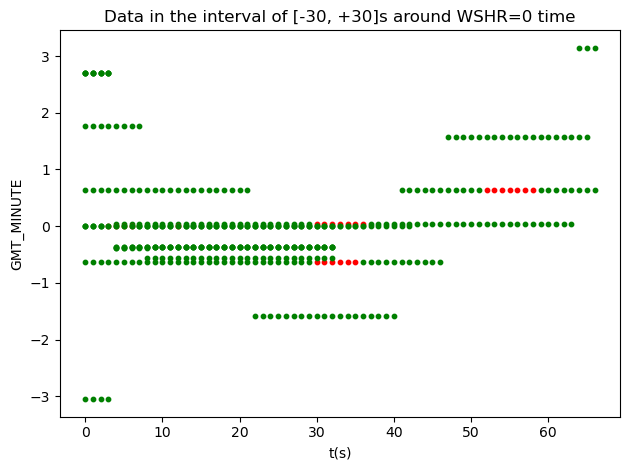

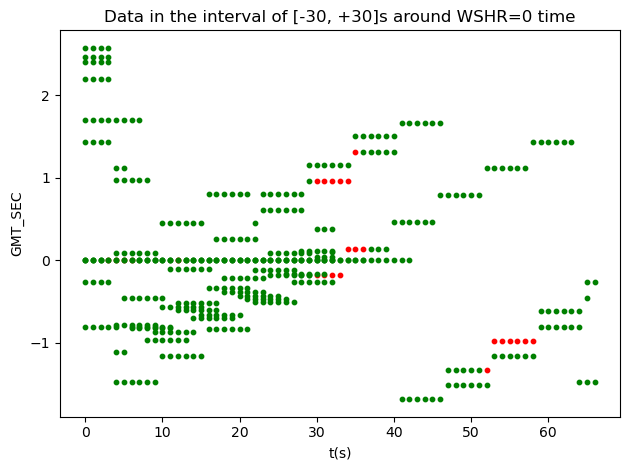

Wind Shear Warns at time [723 724 725 726 727 728 729]
Wind Shear Warns at time [3 4 5 6]
Wind Shear Warns at time [938 939 940 941 942 943]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [12]
Wind Shear Warns at time []
Wind Shear Warns at time []
Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]
Wind Shear Warns at time []
Wind Shear Warns at time []


C:\Users\86108\AppData\Local\Temp\ipykernel_58668\1917142417.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y_array = np.array(Y_array)


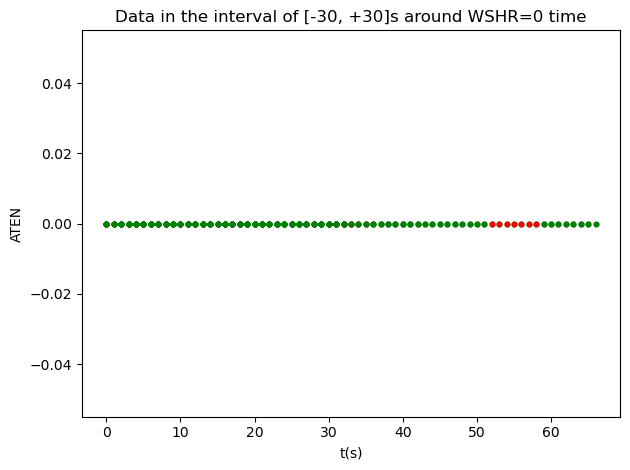

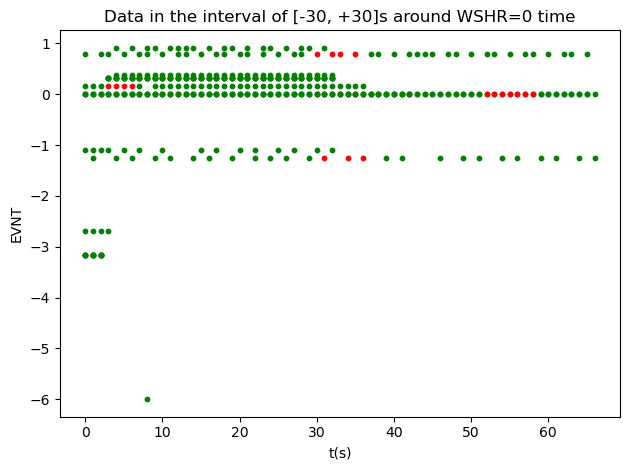

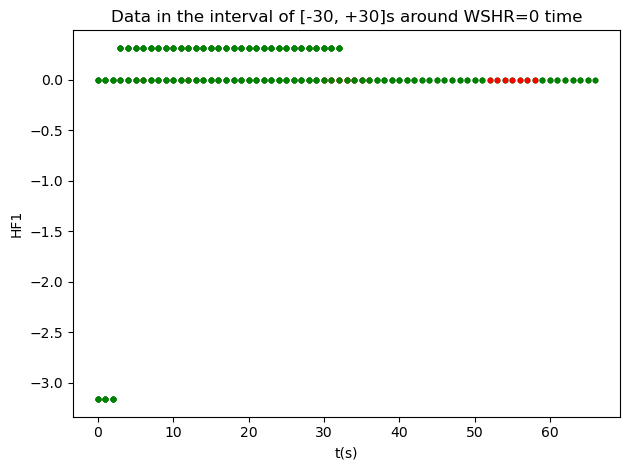

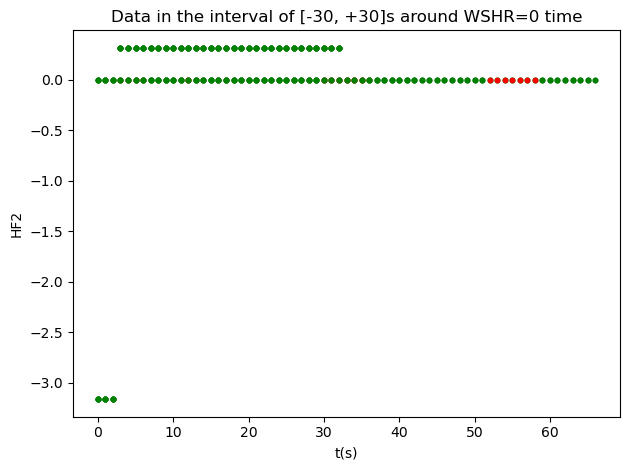

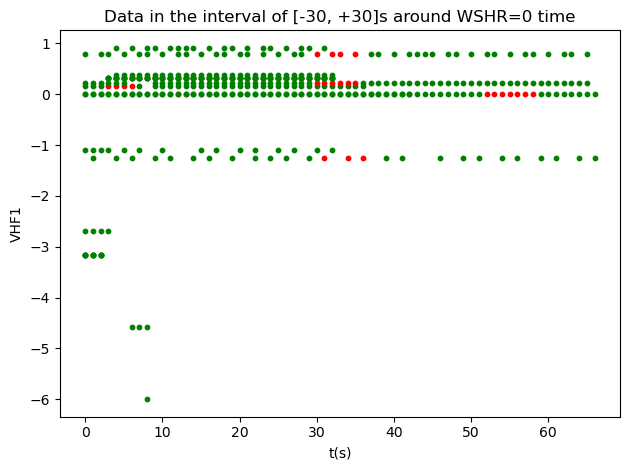

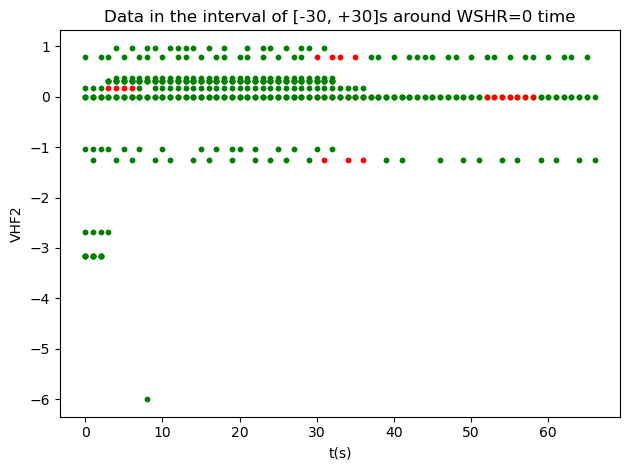

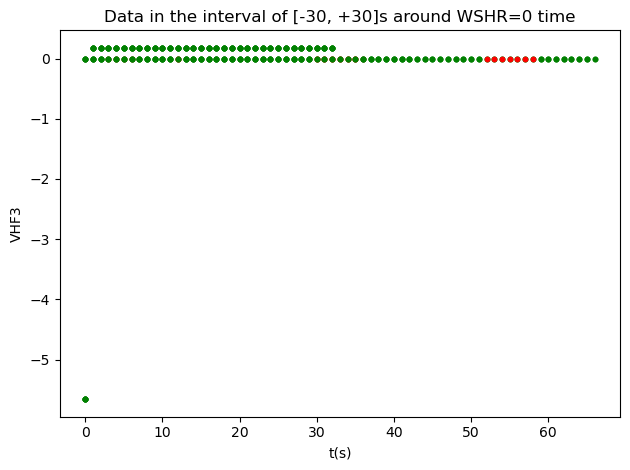

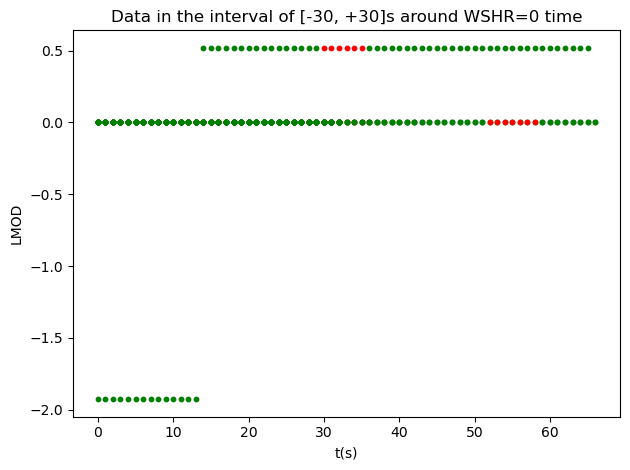

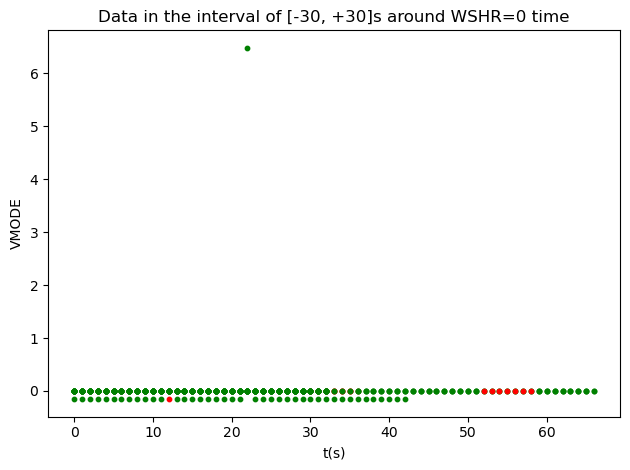

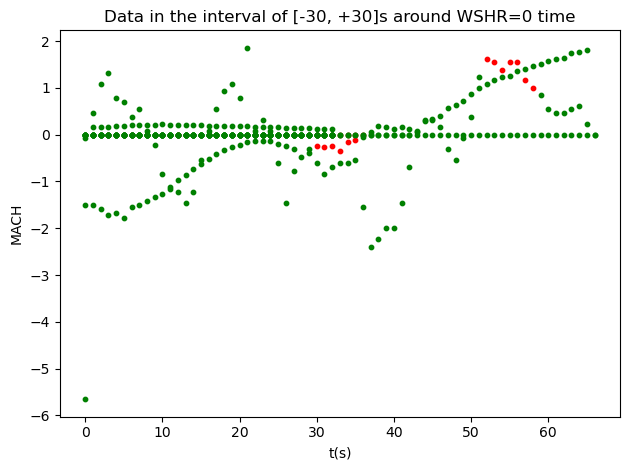

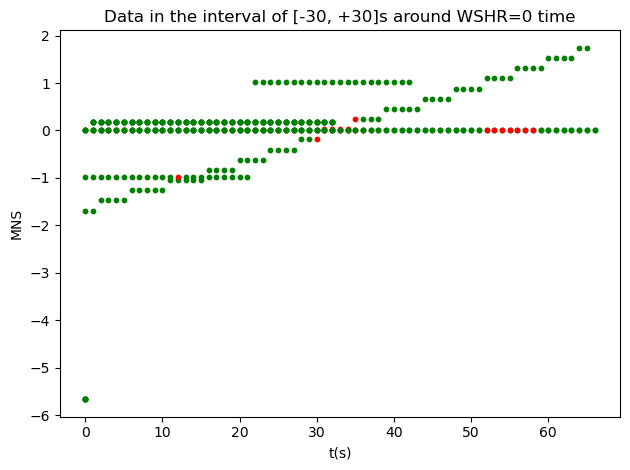

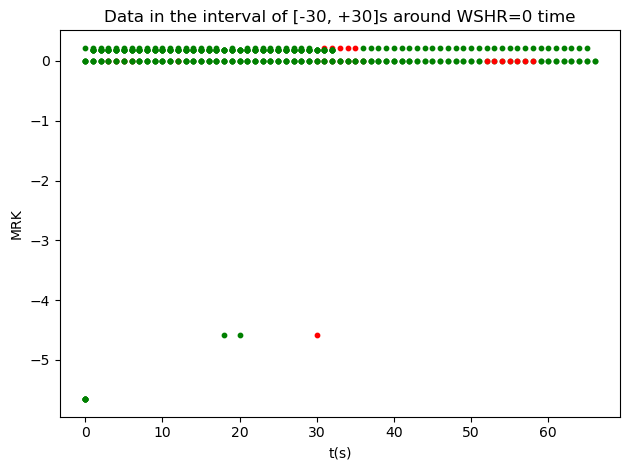

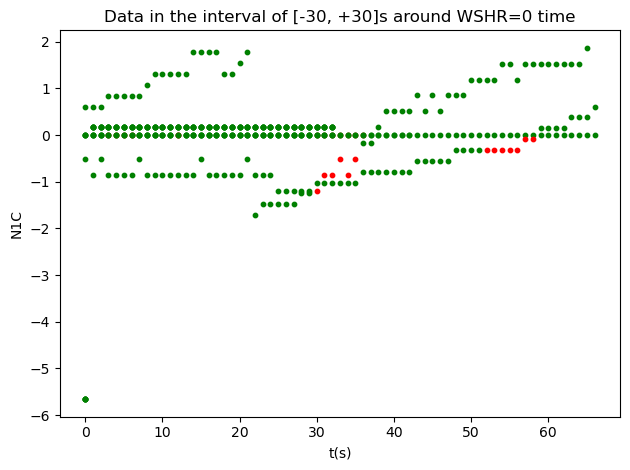

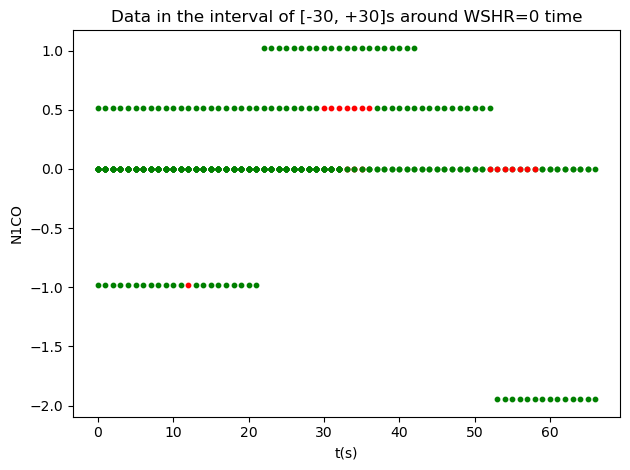

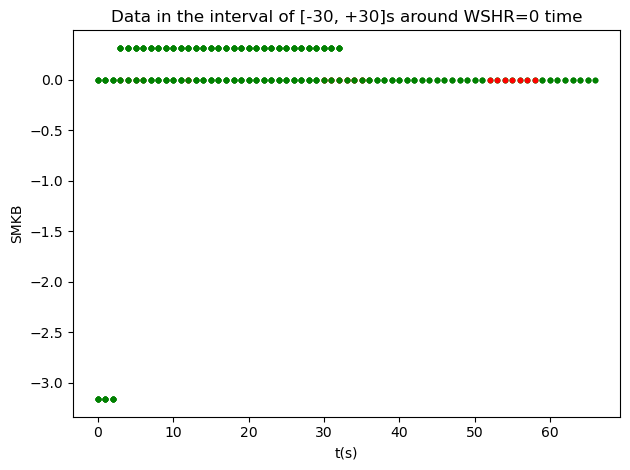

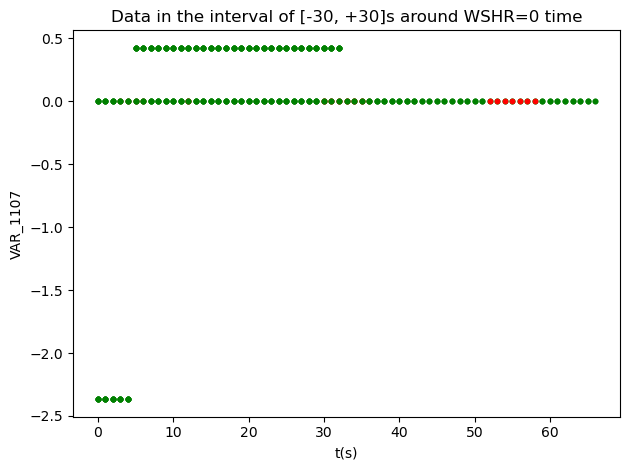

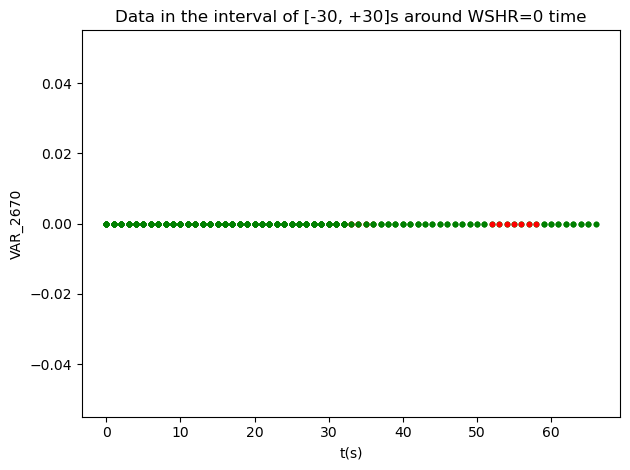

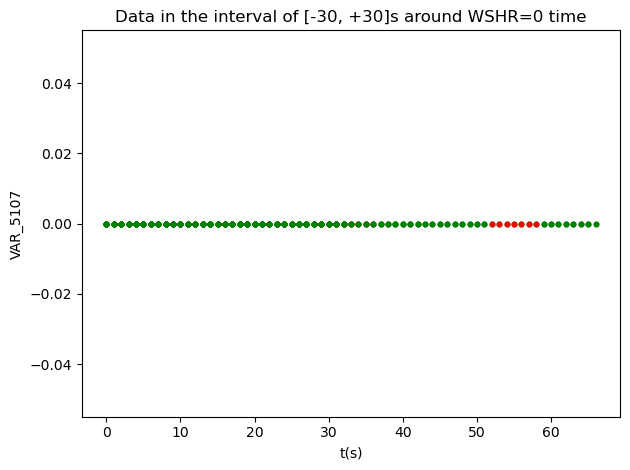

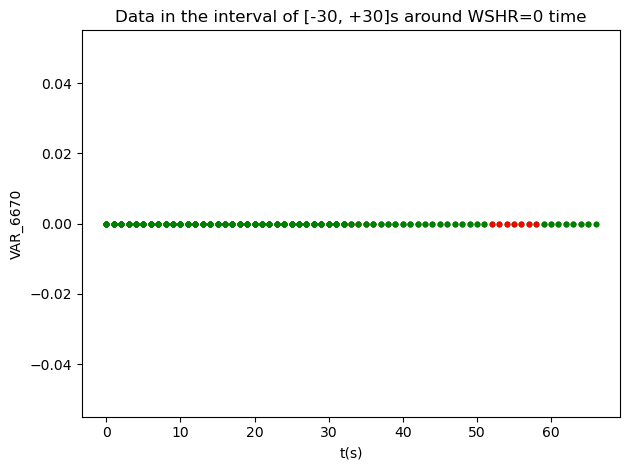

In [93]:
def scatterPlot(work_folder_path, variable_list, group_name, false_alarm_remove = False):
    # 构建数据集
    X_list, Y_list, len_list = [], [], []
    max_length = 0
    for mat_idx, mat_name in enumerate(os.listdir(work_folder_path)):
        X, Y, [left_len, right_len] = dataConstruct_partial(work_folder_path, mat_name, variable_list=variable_list, false_alarm_remove=false_alarm_remove)
        X_list.append(X)
        Y_list.append(Y)
        len_list.append([left_len, right_len])
        if left_len + right_len + 1 > max_length:
            max_length = left_len + right_len + 1
    center_idx = max_length // 2
    # print(max_length, center_idx)
    
    # 中心对齐重新构建列表
    X_array, Y_array = [[] for _ in range(len(variable_list))], [[] for _ in range(len(os.listdir(work_folder_path)))]
    for mat_idx, mat_name in enumerate(os.listdir(work_folder_path)):
        X, Y, [left_len, right_len] = X_list[mat_idx], Y_list[mat_idx], len_list[mat_idx]
        # left_padding, right_padding = center_idx - left_len, center_idx + right_len + 1
        left_padding, right_padding = 0, left_len + right_len + 1
        # print(left_len, right_len, left_padding, right_padding)
        for var_idx, var_name in enumerate(variable_list):
            aligned_list = [X[i-left_padding, var_idx] if i in range(left_padding, right_padding) else None for i in range(max_length)]
            X_array[var_idx].append(aligned_list)
        Y_array[mat_idx] = [Y[i-left_padding] if i in range(left_padding, right_padding) else None for i in range(max_length)]
        # print(X.shape, len(variable_list))
    X_array = np.array(X_array)
    Y_array = np.array(Y_array)
    # print(X_array.shape, Y_array.shape)

    # # 获取异常/正常索引
    # wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    
    # # 计算各变量的异常/正常均值
    # var_avg_list = []
    # # for var_name in variable_list:
    # #     var_idx = find_var_idx(var_name, var_groups_dict)
    # #     var_avg_list.append([np.mean(X[var_idx, wshr_class_idx[0]]), np.mean(X[var_idx, wshr_class_idx[1]])])
    # var_avg_list = [[np.mean(X[wshr_class_idx[0], var_idx]), np.mean(X[wshr_class_idx[1], var_idx])] for var_idx in range(X.shape[0])]
    # var_avg_diff_list = [np.abs(var_avg_list[i][0] - var_avg_list[i][1]) for i in range(len(variable_list))]
    # # # 找到均值最大的变量作为x轴
    # # max_avg_diff_idx = np.argmax(var_avg_diff_list)
    # # 

    # 生成存储路径
    plt_save_path = os.path.join('../result/variable_plots', work_folder_path.split('\\')[-1])
    if os.path.exists(plt_save_path) == False:
        os.mkdir(plt_save_path)
    # plt_save_path = os.path.join(plt_save_path, work_mat_name)
    # if os.path.exists(plt_save_path) == False:
    #     os.mkdir(plt_save_path)
    plt_save_path = os.path.join(plt_save_path, group_name)
    if os.path.exists(plt_save_path) == False:
        os.mkdir(plt_save_path)

    # for i in range(len(variable_list)):
    #     plt.figure()
    #     plt.scatter(X[max_avg_diff_idx, wshr_class_idx[0]], X[i, wshr_class_idx[0]], c='red', s = 10, label='WSHR = 0')
    #     plt.scatter(X[max_avg_diff_idx, wshr_class_idx[1]], X[i, wshr_class_idx[1]], c='green', s = 10, label='WSHR = 1')
    #     plt.title(f'Data in the interval of [-30, +30]s around WSHR=0 time')
    #     plt.xlabel(variable_list[max_avg_diff_idx])
    #     plt.ylabel(variable_list[i])
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig(os.path.join(plt_save_path, f'{variable_list[i]}_{variable_list[max_avg_diff_idx]}.png'))
    #     plt.show()
        
    for var_idx in range(len(variable_list)):
        plt.figure()
        for mat_idx, mat_name in enumerate(os.listdir(work_folder_path)):
            wshr_class_idx = [np.where(Y_array[mat_idx] == 0)[0], np.where(Y_array[mat_idx] == 1)[0]]
            # print(wshr_class_idx[0])
            plt.scatter(wshr_class_idx[0], X_array[var_idx, mat_idx, wshr_class_idx[0]], c='red', s = 10)
            plt.scatter(wshr_class_idx[1], X_array[var_idx, mat_idx, wshr_class_idx[1]], c='green', s = 10)
        plt.title(f'Data in the interval of [-30, +30]s around WSHR=0 time')
        plt.xlabel('t(s)')
        plt.ylabel(variable_list[var_idx])
        # plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(plt_save_path, f'{variable_list[var_idx]}.png'))
        plt.show()
    
    # return var_avg_list, var_avg_diff_list

# 对work_path下所有mat文件，记录各变量的wshr异常点/前后30s正常点的数据，并以每类变量中均值差别最大的为基准，打印散点图
for group_name, var_list in var_groups_dict.items():
    scatterPlot(work_folder_path, variable_list=var_list, group_name=group_name, false_alarm_remove=True)
    # break